In [94]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import MLModels


from xgboost import XGBClassifier

from sklearn.metrics import r2_score
import sklearn.linear_model
from sklearn.linear_model import LinearRegression

from sklearn.metrics import roc_curve, auc

# debug mode (spits messages verbosely)
DEBUG = 0  # change it to 0 to switch it off

loc="../../../WES/Clinical Data/Raw/"
outdata="../../../WES/Clinical Data/Processed/"

In [95]:
#importing the required dependencies.
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pylab as pl
import shap
shap.initjs()

regr = LinearRegression()
xgb_m=xgb.XGBRegressor(random_state=42, base_score=0.5)

def findcols(df,txt):
    cols=[col for col in df.columns if txt in col]
    return cols

def datacleaner(df):
    for col in df.columns:
        masknotna=(df[col][pd.notnull(df[col])])
        df[col]=df[col].fillna(df[col][masknotna].mean())
    return df
    

def umap_reducer(df,vars,neighb=10,comp=5,depvar='Hoehn and Yahr'):
    dmod=df[[col for col in vars if col!='SYDID' and col!=depvar and df[col].dtype!='object']]
    print(dmod.shape)
    
    reducer= umap.UMAP(n_neighbors=neighb,n_components=comp)
    reddata = reducer.fit_transform(dmod)
    return reddata


def model_fit(df,depvar,model=xgb_m):
    X = df.drop([depvar,'SYDID'], axis  = 1)
    #setting y as the target variable
    y = df[depvar]
   
    #Splitting the dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 100)
    model = model
    model.fit(X_train,y_train)
    
    print(model.score(X_train, y_train)) 
    print(model.score(X_test, y_test) )
    
    print(model.score(X, y) )
    
    
    
    y_pred = model.predict(X_test)
    
    df=pd.DataFrame({'actual':y_test,'predicted':y_pred}).sort_values(by='actual').reset_index()
    df['index']=np.arange(df.shape[0])
    df.groupby('index')['actual','predicted'].mean().plot(kind='line')
    plt.show()
    
    rsq=r2_score(y_pred, y_test) 

    rsq2=r2_score(y_pred, y_test, multioutput='variance_weighted')
    
    print(rsq)
    
    exp = shap.TreeExplainer(model)
    shap_values = exp.shap_values(X_test)
    shap.summary_plot(shap_values, X_test)
    plt.show()
    
    shap_values_df=pd.DataFrame(shap_values,columns=X_test.columns)
    shap_values_df=pd.DataFrame(shap_values_df.mean()).reset_index()
    shap_values_df.columns=['variable','mean_shap']
    shap_values_df['abs_mean_shap']=abs(shap_values_df['mean_shap'])
    shap_values_df.sort_values(by='abs_mean_shap',ascending=False,inplace=True)

    
    return model,y_test,y_pred,shap_values_df


def model_fit_class(df,depvar,umap=0,umap_comp=5,umap_neigh=20):
    colrem1=[col for col in df.columns if not re.search('int|float',str(df[col].dtype))]
    #print(colrem1)
    colsrem=np.append(depvar,colrem1)
    #print(colsrem)
    X = df.drop(colsrem, axis  = 1)
    #setting y as the target variable
    y = df[depvar]
    
    if umap==1:
        cols=[col for col in X.columns if not re.search('Scwab|ratio|Digit|chg',col) ]

        X=umap_reducer(X,cols,neighb=umap_neigh,comp=umap_comp,depvar='DDE')
        X=pd.DataFrame(X)
        X.columns=['U'+str(col) for col in X.columns]

   
    #Splitting the dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 100)
    model = xgb.XGBClassifier(random_state=42, base_score=0.5)
    model.fit(X_train,y_train)
    
  
    y_pred = model.predict(X_test)
    
    y_score = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
    
    print(roc_auc)
    
    exp = shap.TreeExplainer(model)
    shap_values = exp.shap_values(X_test)
    shap.summary_plot(shap_values, X_test)
    plt.show()

    
    return model,y_test,y_pred

In [96]:

def colsize(df,col):
    colsize=df[col].isnull().sum(axis = 0)/df.shape[0]
    return colsize
        
def clustervars_func(df,mincolsize=0.1):
    #print(udprs_cog_moc[col].isnull().sum(axis = 0))
    
   

    clustervars=[col for col in df.columns if col!='SYDID' 
              and not re.search('FOG',col) and not re.search('Date',col) and colsize(df,col)<mincolsize]
    return clustervars

def correlations(df,clustervars,depvar,plot=1,corr_thresh=0.1):
    vars=np.array([])
    corrs=np.array([])
    for var in clustervars:
        if var!='SYDID':
            
            
            
            if (df[var].dtype=='int64' or df[var].dtype=='float64') and len(df[var])>=10:
                try:
                    #print(var)
                    mask=(pd.notnull(df[var]))&(pd.notnull(df[depvar]))
                    corr, _ = pearsonr(df[var][mask], df[depvar][mask])
                    vars=np.append(vars,var)
                    corrs=np.append(corrs,corr)
                    
                    #print(var+': Pearsons correlation: %.3f' % corr)
                    if plot==1:
                        plt.scatter(df[var], df[depvar])
                        plt.title(var)
                        plt.show()
                except:
                    pass
    df_out=pd.DataFrame({'var':vars,'corr':corrs})
    df_out.sort_values(by='corr',ascending=False,inplace=True)
    
    for var in df_out['var'].head(20):
        print(df[var].nunique())
        if df[var].nunique()>100:
            plt.scatter(df[var], df[depvar])
            plt.title(var)
            plt.show()
        else:
            df.groupby(var)[depvar].mean().plot(kind='bar')
            plt.show()
        
    return df_out

In [97]:
PDCombined=pd.read_csv('%s%s' % (outdata,'PDcombined.csv'))

In [98]:
mask_male=(PDCombined['udprs_Gend']=="Male")
PDCombined['Male']=0
PDCombined['Male'][mask_male]=1


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [99]:
findcols(PDCombined,'Weighted')

['PDQ_Weighted',
 'pct_chgPDQ_Weighted',
 'chg_PDQ_Weighted',
 'PDQ_Weighted_intercept',
 'PDQ_Weighted_coef',
 'PDQ_Weighted_min_date',
 'PDQ_Weighted_max_date',
 'PDQ_Weighted_counts',
 'chg_maxPDQ_Weighted',
 'chg_minPDQ_Weighted']

In [100]:
maskfog=(PDCombined['FOGQ_FOGQ 3']>0)
masknofog=(PDCombined['FOGQ_FOGQ 3']==0)

PDCombined['no_fog']=0
PDCombined['no_fog'][masknofog]=1
PDCombined['no_fog']=PDCombined.groupby('SYDID')['no_fog'].transform('max')

masknofog2=(PDCombined['no_fog']==1)


PDCombined['FOG_Date']=PDCombined[maskfog&masknofog2].groupby('SYDID')['Date of assessment'].transform('min')

# df['recs']=(df.groupby('SYDID')['SYDID'].transform('count'))


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [101]:
PDCombined['gate_freeze_days']=(pd.to_datetime(PDCombined['FOG_Date'])-
                                   pd.to_datetime(PDCombined['udprs_Date Diagnosed'])).dt.days

In [102]:
PDCombined.shape

(260, 545)

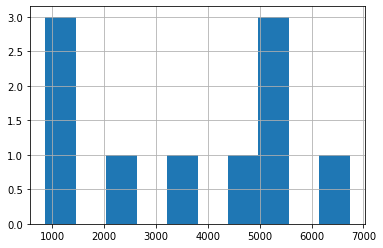

In [103]:
PDCombined['gate_freeze_days'].hist()

In [104]:
clustervars2=clustervars_func(PDCombined,1)

In [105]:
findcols(PDCombined,'Total REMSBD')

['RBDQ_Total REMSBD']

In [106]:
clustervars=['SYDID','udprs_tremor_coef','udprs_non_tremor_coef',
 'udprs_SectionIIITotal_coef','udprs_MMSEresult_coef','udprs_MoCATotal_coef','udprs_Age_Diagnosis','udprs_tremor',
             'udprs_non_tremor','FOGQ_FOGQ 3',
             'udprs_Section III Total','cog1_MMSE result','moca_MoCA Total','PDQ_total PDQ-39','udprs_DDE',
             'RBDQ_Total REMSBD','PDQ_Weighted']

clustervars=['SYDID','udprs_Section II Total','udprs_Section III Total','udprs_tremor','udprs_non_tremor',
             'FOGQ_FOGQ 3','udprs_Section IV Total','cog1_MMSE result','moca_MoCA Total','PDQ_total PDQ-39',
             'udprs_DDE','udprs_Hoehn and Yahr','RBDQ_Total REMSBD','PDQ_Weighted']

In [107]:
colrem1=[col for col in PDCombined.columns if not re.search('int|float',str(PDCombined[col].dtype))]

In [108]:

df=datacleaner(PDCombined)

mask_class=(df['udprs_Hoehn and Yahr']>2)
df['HY']=0
df['HY'][mask_class]=1


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [109]:
def classbreak(df,var,cutoff):
    df['class_'+str(var)]=0
    mask_ctoff=(df[var]>cutoff)
    df['class_'+str(var)][mask_ctoff]=1
    print(df['class_'+str(var)].value_counts())
    return df
    

In [110]:
def preprocesscols(df=PDCombined,depvar='total PDQ-39',remstring='PDQ'):

    cols=[col for col in df.columns if df[col].dtype!='object' 
          and not re.search(remstring,col)]
    df_temp=df[cols]
    df_out=df[np.append(cols,['SYDID',depvar])]

    for col in df_temp.columns:
        df_out[col].fillna(df_out[col].mean(),inplace=True)
        df_out[col]=df_out[col].round(2)
        
    return df_out




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Series.base is deprecated and will be removed in a future version


[21:04:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9892446545404704
0.36187053521990675
0.8585417933974143


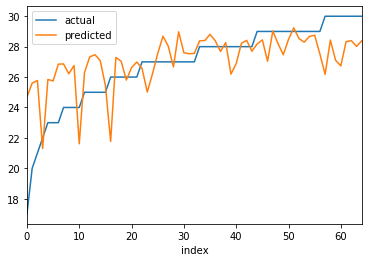

-0.6964368863133372


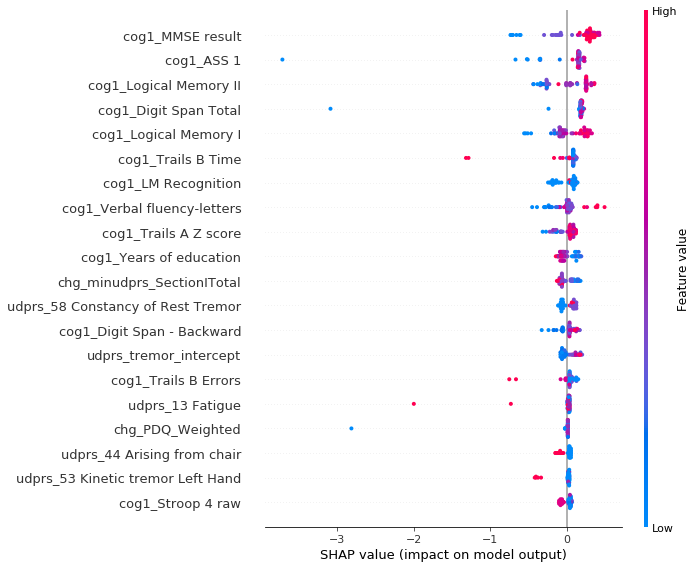

In [111]:
check2=preprocesscols(df=PDCombined,depvar='moca_MoCA Total',remstring='moca')
model,y_test,y_pred,moca_shap=model_fit(check2,'moca_MoCA Total',model=xgb_m)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Series.base is deprecated and will be removed in a future version


[21:04:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9917689032645504
0.6711283482965746
0.9109052412488758


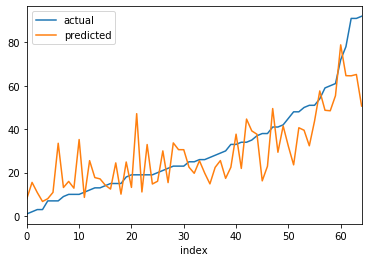

0.4188472408978152


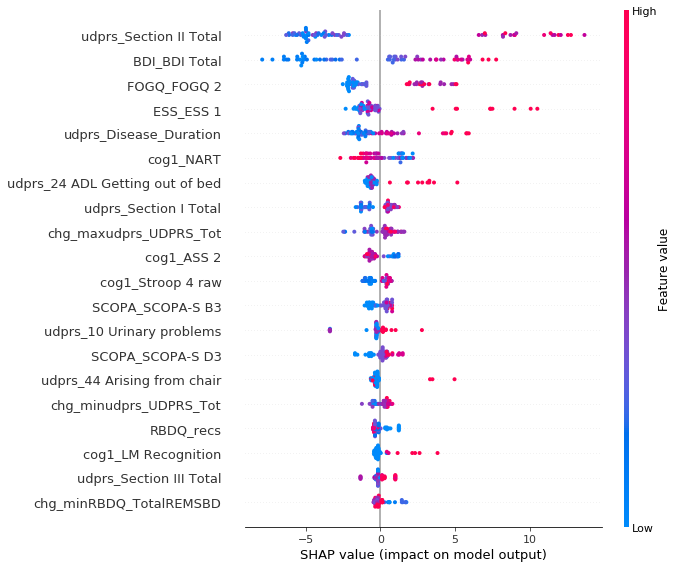

In [112]:
pdqdata=preprocesscols(df=PDCombined,depvar='PDQ_total PDQ-39',remstring='PDQ')
model,y_test,y_pred,pdq_shap=model_fit(pdqdata,'PDQ_total PDQ-39',model=xgb_m)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Series.base is deprecated and will be removed in a future version


[21:07:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9921541495941852
0.6779469942764745
0.9141384224440051


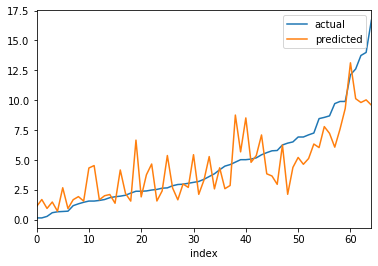

0.4395209783267279


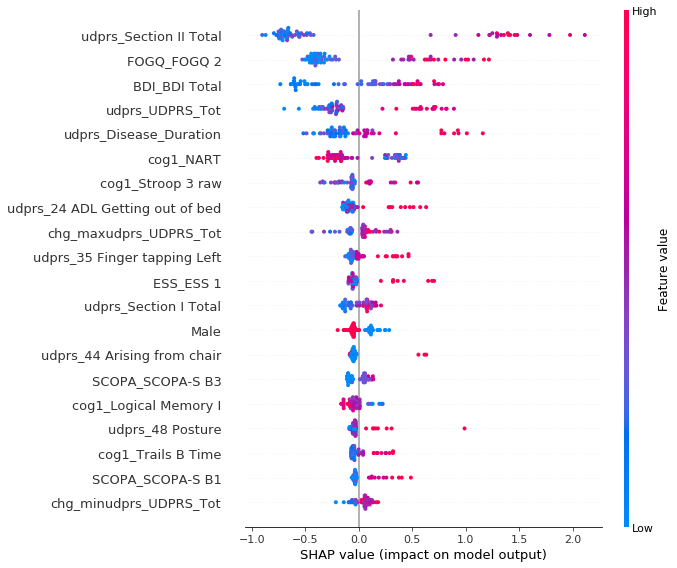

In [116]:
pdqdata=preprocesscols(df=PDCombined,depvar='PDQ_Weighted',remstring='PDQ|recs')
model,y_test,y_pred,pdq_shap=model_fit(pdqdata,'PDQ_Weighted',model=xgb_m)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Series.base is deprecated and will be removed in a future version


[06:16:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9712867853449072
0.47423267547732895
0.8133562900783149


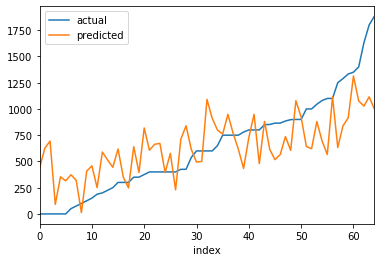

-0.560315171808615


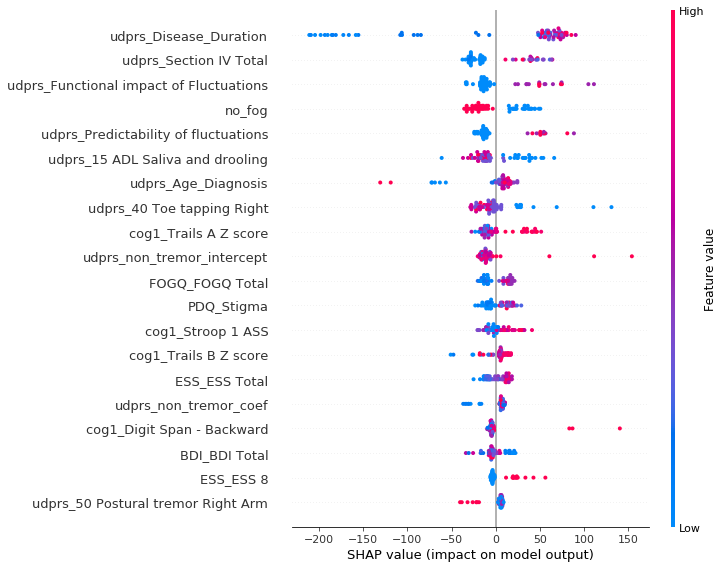

ValueError: too many values to unpack (expected 3)

In [23]:
check2=preprocesscols(df=PDCombined,depvar='udprs_DDE',remstring='DDE|L-dopa|dose|Off|medication')
model,y_test,y_pred=model_fit(check2,'udprs_DDE',model=xgb_m)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Series.base is deprecated and will be removed in a future version


[22:22:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9914322549896775
0.24480823570232546
0.8101850937902959


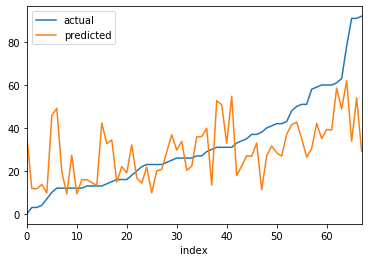

-0.9707936609380898


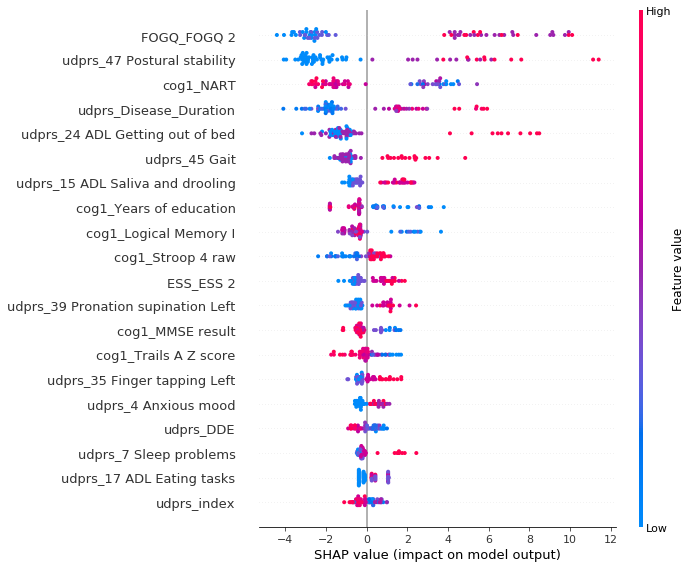

In [1257]:
check2=preprocesscols(df=PDCombined,depvar='PDQ_total PDQ-39',remstring='PDQ|Tot|Total')

model,y_test,y_pred,shap_values_df=model_fit(check2,'PDQ_total PDQ-39',model=xgb_m)

In [1256]:
PDCombined[np.asarray(shap_values_df['variable'].head(20))]

,FOGQ_FOGQ 2,udprs_Section II Total,udprs_Section I Total,udprs_Disease_Duration,cog1_NART,udprs_UDPRS_Tot,udprs_47 Postural stability,udprs_45 Gait,udprs_time_since_first,ESS_ESS 1,chg_minudprs_DDE,udprs_24 ADL Getting out of bed,chg_maxRBDQ_TotalREMSBD,udprs_3 Depressed mood,udprs_SectionIITotal_intercept,chg_maxudprs_DDE,FOGQ_FOGQ Total,cog1_Years of education,no_fog,udprs_2 Hallucinations and Psychosis
0,0.595745,14.0,10.0,2096.0,89.0,62.0,2.0,2.0,1197.0,2.0,104.166667,0.0,5.102041,0.0,14.000000,135.344828,6.937107,10.0,0,1.0
1,1.000000,20.0,18.0,1546.0,102.0,76.0,1.0,2.0,581.0,3.0,104.166667,1.0,5.102041,0.0,20.000000,135.344828,12.000000,12.0,0,2.0
2,0.000000,3.0,1.0,1188.0,112.0,19.0,0.0,1.0,329.0,2.0,125.000000,0.0,6.000000,0.0,3.942507,600.000000,1.000000,17.0,1,0.0
3,0.000000,6.0,3.0,1573.0,112.0,16.0,0.0,0.0,714.0,2.0,125.000000,0.0,6.000000,0.0,3.942507,600.000000,1.000000,17.0,1,0.0
4,0.000000,3.0,1.0,1930.0,112.0,12.0,0.0,1.0,1071.0,2.0,125.000000,0.0,6.000000,0.0,3.942507,600.000000,1.000000,17.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,1.000000,12.0,8.0,2115.0,107.0,62.0,1.0,1.0,0.0,3.0,104.166667,1.0,5.102041,0.0,12.000000,135.344828,1.000000,16.0,1,0.0
268,0.000000,16.0,10.0,689.0,113.0,50.0,0.0,1.0,0.0,3.0,104.166667,1.0,5.102041,0.0,16.000000,135.344828,2.000000,11.0,1,1.0
269,0.595745,13.0,6.0,2501.0,103.0,45.0,0.0,1.0,0.0,0.0,104.166667,1.0,5.102041,0.0,13.000000,135.344828,6.937107,10.0,0,0.0
270,0.000000,15.0,8.0,7.0,115.0,63.0,0.0,2.0,0.0,1.0,104.166667,2.0,5.102041,1.0,15.000000,135.344828,1.000000,16.0,1,0.0


In [25]:
mod_data_simp=PDCombined[['SYDID','Section II Total','Section III Total','tremor','non_tremor','FOGQ 3',
                             'Section IV Total','MMSE result','MoCA Total','total PDQ-39','DDE','Hoehn and Yahr','Total REMSBD']]

#mod_data_simp=udprs_cog_moc[['SYDID','Section III Total','total PDQ-39']]

model,y_test,y_pred=model_fit(check,'total PDQ-39',model=xgb_m)

KeyError: "['Hoehn and Yahr', 'tremor', 'DDE', 'total PDQ-39', 'MoCA Total', 'Section III Total', 'non_tremor', 'Section IV Total', 'Total REMSBD', 'MMSE result', 'FOGQ 3', 'Section II Total'] not in index"

In [27]:
df=classbreak(df,'MoCA Total',24)



dropcols=[col for col in findcols(df,'MoCA') if 'class' not in col]
#dropcols=np.append(dropcols,findcols(df,'Freez'))
#dropcols=np.append(dropcols,findcols(df,'recs'))

model_fit_class(df.drop(columns=dropcols),'class_MoCA Total',umap=0,umap_comp=9,umap_neigh=20)

KeyError: 'MoCA Total'

In [28]:
findcols(PDCombined,'FOGQ 3')

['FOGQ_FOGQ 3']

In [29]:
fog_df=preprocesscols(df=PDCombined,depvar='FOGQ_FOGQ 3',remstring='FOG|Freez|freez|fog|recs')



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataF

0    187
1     73
Name: class_FOGQ_FOGQ 3, dtype: int64
0.8566666666666667


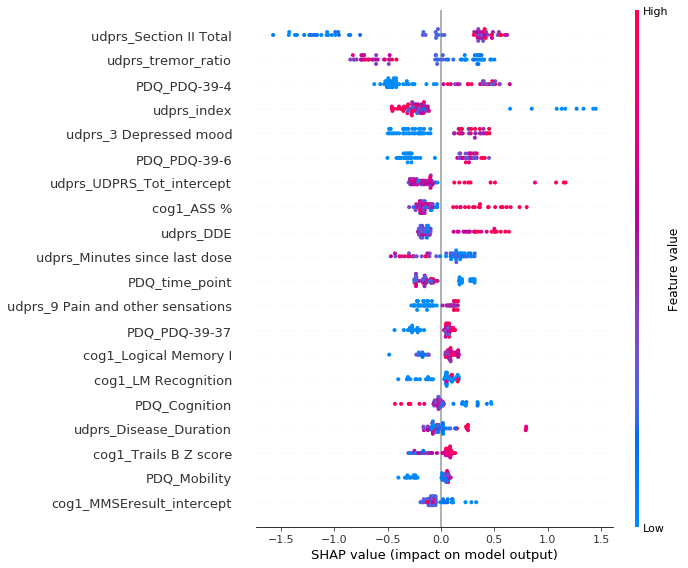

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               learning_rate=0.1, max_delta_step=0, max_depth=3,
               min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
               nthread=None, objective='binary:logistic', random_state=42,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=1, verbosity=1), 148    0
 96     0
 177    0
 225    0
 236    1
       ..
 19     0
 124    0
 111    0
 203    0
 251    1
 Name: class_FOGQ_FOGQ 3, Length: 65, dtype: int64, array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]))

In [30]:
fog_df=preprocesscols(df=PDCombined,depvar='FOGQ_FOGQ 3',remstring='FOG|Freez|freez|fog|recs')

fog_df=classbreak(fog_df,'FOGQ_FOGQ 3',0.9)
fog_df=fog_df.drop(columns='FOGQ_FOGQ 3')
#dropcols=[col for col in findcols(df,'FOGQ') if 'class' not in col]
#dropcols=np.append(dropcols,findcols(df,'Freez'))
#dropcols=np.append(dropcols,findcols(df,'recs'))

model_fit_class(fog_df,'class_FOGQ_FOGQ 3',umap=0,umap_comp=9,umap_neigh=20)

In [31]:
findcols(PDCombined,'Reading')

[]

In [32]:
df=classbreak(df,'DDE',500)
dropcols=[col for col in findcols(df,'DDE') if 'class' not in col]
model_fit_class(df.drop(columns=dropcols),'class_DDE',umap=0,umap_comp=9,umap_neigh=20)

KeyError: 'DDE'


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    153
0    113
Name: class_DDE, dtype: int64
(266, 173)
0.5168855534709194


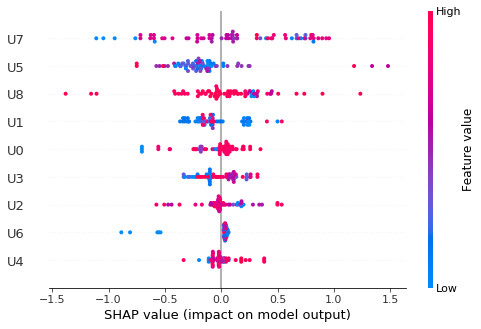

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               learning_rate=0.1, max_delta_step=0, max_depth=3,
               min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
               nthread=None, objective='binary:logistic', random_state=42,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=1, verbosity=1), 188    1
 112    1
 62     1
 142    1
 221    1
       ..
 134    1
 220    0
 233    0
 197    0
 120    1
 Name: class_DDE, Length: 67, dtype: int64, array([1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
        1]))

In [923]:
df=classbreak(df,'DDE',500)
dropcols=[col for col in findcols(df,'DDE') if 'class' not in col]
model_fit_class(df.drop(columns=dropcols),'class_DDE',umap=1,umap_comp=9,umap_neigh=20)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0    134
1    132
Name: class_total PDQ-39, dtype: int64
0.8502722323049001


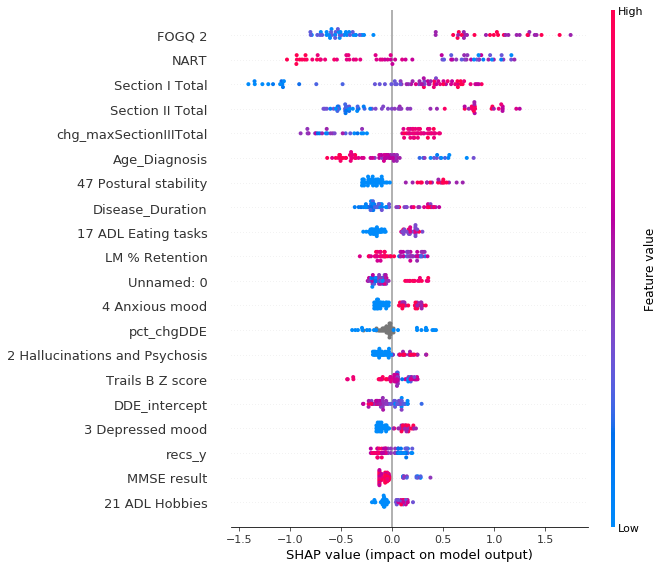

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               learning_rate=0.1, max_delta_step=0, max_depth=3,
               min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
               nthread=None, objective='binary:logistic', random_state=42,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=1, verbosity=1), 188    1
 112    0
 62     1
 142    1
 221    0
       ..
 134    1
 220    1
 233    0
 197    1
 120    0
 Name: class_total PDQ-39, Length: 67, dtype: int64, array([1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0]))

In [889]:
df=classbreak(df,'total PDQ-39',23)
dropcols=[col for col in findcols(df,'PDQ') if 'class' not in col]
model_fit_class(df.drop(columns=dropcols),'class_total PDQ-39')


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    156
0    110
Name: class_Section III Total, dtype: int64
0.958498023715415


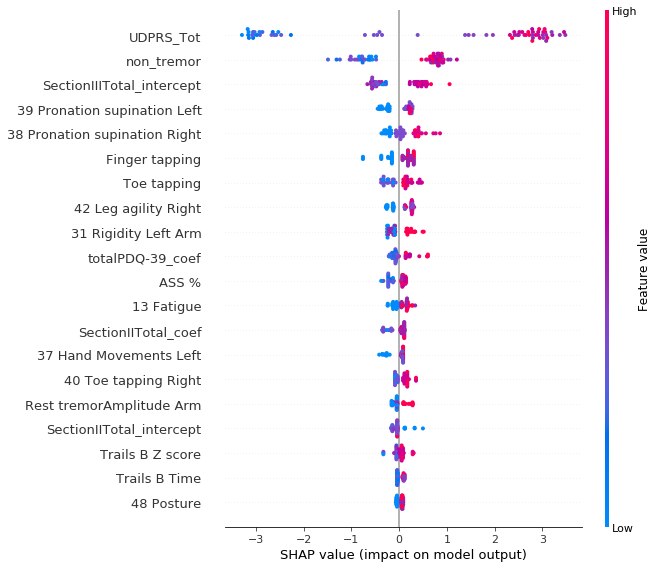

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               learning_rate=0.1, max_delta_step=0, max_depth=3,
               min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
               nthread=None, objective='binary:logistic', random_state=42,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=1, verbosity=1), 188    1
 112    0
 62     1
 142    1
 221    1
       ..
 134    1
 220    1
 233    0
 197    0
 120    1
 Name: class_Section III Total, Length: 67, dtype: int64, array([1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
        1]))

In [890]:
df=classbreak(df,'Section III Total',23)
dropcols=[col for col in findcols(df,'Section III') if 'class' not in col]
model_fit_class(df.drop(columns=dropcols),'class_Section III Total')

In [828]:
udprs_cog_moc['HY'].value_counts()

0    191
1     75
Name: HY, dtype: int64

(266, 173)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
Series.base is deprecated and will be removed in a future version


[01:13:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
-0.6120298621016091


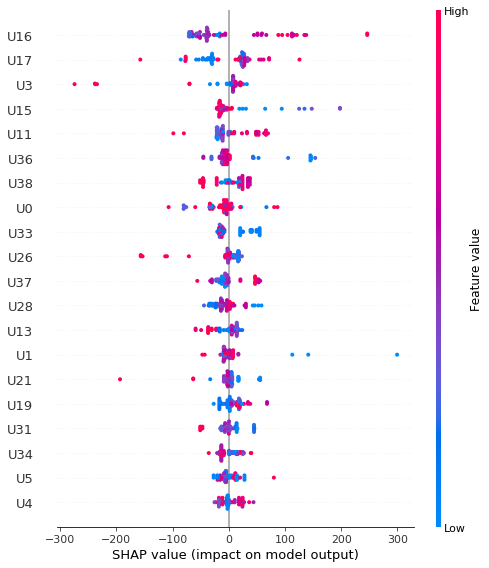

In [821]:
cols=[col for col in arr if not re.search('Scwab|ratio|Digit|chg',col) ]

X_Um=umap_reducer(udprs_cog_moc,cols,neighb=5,comp=40,depvar='DDE')

X_Um=pd.DataFrame(X_Um)
X_Um.columns=['U'+str(col) for col in X_Um.columns]

mod_data_umap=pd.concat([udprs_cog_moc[['SYDID','DDE']],X_Um],axis=1)

model,y_test,y_pred=model_fit(mod_data_umap,'DDE')

In [817]:
for col in check.columns:
    a=check[pd.isnull(check[col])].shape[0]
    b=check[(check[col]>10000)|(check[col]<-10000)].shape[0]
    if a>0:
        print(a)
        print(col)

In [586]:

check2=udprs_cog_moc[[col for col in clustervars2 if col!='SYDID']]
cols=[col for col in udprs_cog_moc.columns if udprs_cog_moc[col].dtype!='object' and col!='DDE' and col!='Digit Span']
check2=udprs_cog_moc[cols]

for col in check.columns:
    check2[col].fillna(check2[col].mean(),inplace=True)
    check2[col]=check2[col].round(2)


        
reducer= umap.UMAP(n_neighbors=10,n_components=5)
X_Um = reducer.fit_transform(check)

X_Um=pd.DataFrame(X_Um)
X_Um.columns=['U'+str(col) for col in X_Um.columns]

mod_data_umap=pd.concat([udprs_cog_moc[['SYDID','DDE']],X_Um],axis=1)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ValueError: could not convert string to float: 'On'

In [536]:
#embedding = umap.UMAP(n_neighbors=5,metric='correlation').fit_transform(check)

Series.base is deprecated and will be removed in a future version


[00:18:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9958892647257408


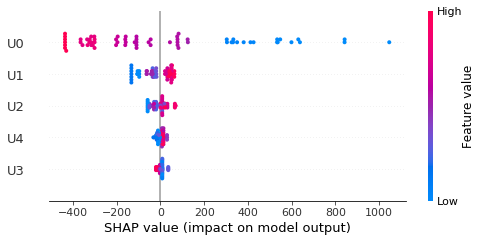

In [544]:
model,y_test,y_pred=model_fit(mod_data_umap,'DDE')

In [546]:
y_pred

array([1.5981978e+03, 8.6504071e+02, 9.0704907e+02, 6.8915710e+02,
       6.0583081e+02, 2.2681160e+02, 5.2821307e+02, 7.6434540e+02,
       1.3502490e+02, 5.4751453e+02, 7.7668469e+02, 7.5630927e+02,
       1.7987669e+00, 3.0306320e+02, 5.4751453e+02, 7.6685467e+00,
       1.7987669e+00, 1.8014452e+03, 1.7987669e+00, 1.3484183e+03,
       8.9732294e+02, 1.5989205e+03, 4.9078848e+02, 7.9155127e+02,
       4.5256122e+02, 5.2821307e+02, 8.6204547e+02, 1.7987669e+00,
       8.5853668e+02, 3.5082501e+02, 1.1223438e+03, 1.3270876e+02,
       1.0989559e+03, 1.7987669e+00, 3.0220544e+02, 3.9946082e+02,
       9.5241913e+02, 6.0583081e+02, 1.2630162e+03, 6.0627032e+02,
       6.8959662e+02, 7.7482056e+02, 1.0777107e+03, 7.3131854e+02,
       9.1664453e+02, 6.7455792e+02, 3.0277026e+02, 4.5256122e+02,
       3.9786218e+02, 2.8531763e+02, 2.5214558e+02, 6.0583081e+02,
       7.9762286e+02, 1.3502490e+02, 6.0583081e+02, 2.5214558e+02,
       5.9979834e+02, 3.8793579e+02, 7.5630927e+02, 8.9258307e

In [545]:
y_test

188    1548.0
112     885.0
62      950.0
142     665.0
221     600.0
        ...  
134    1475.0
220     400.0
233       0.0
197     475.0
120    1100.0
Name: DDE, Length: 67, dtype: float64

In [450]:
clustervars2=clustervars_func(udprs_cog_moc,0.1)

6


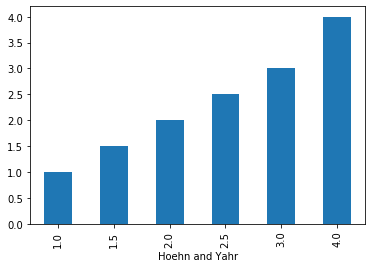

79


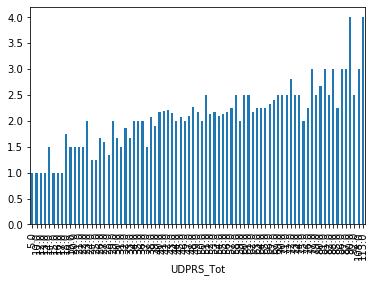

46


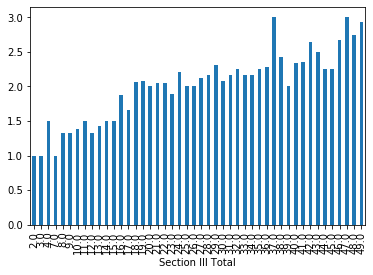

4


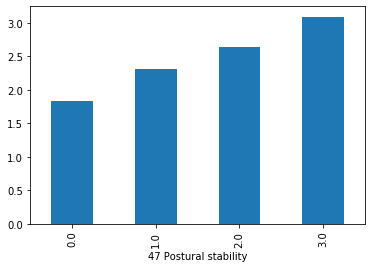

30


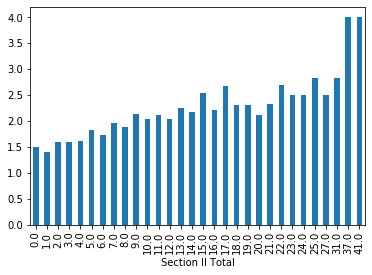

5


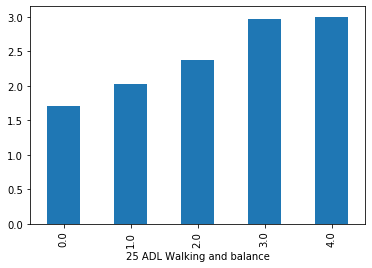

25


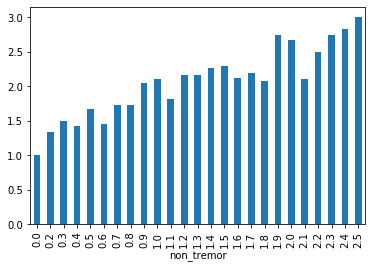

5


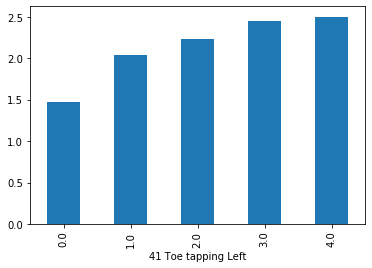

4


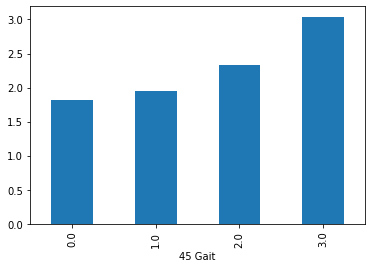

4


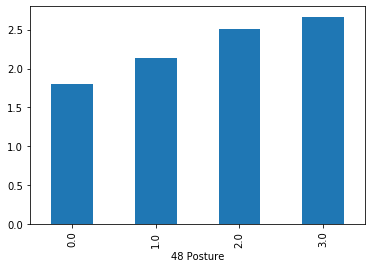

5


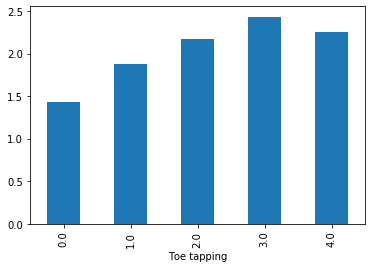

5


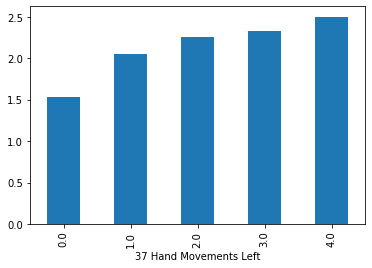

73


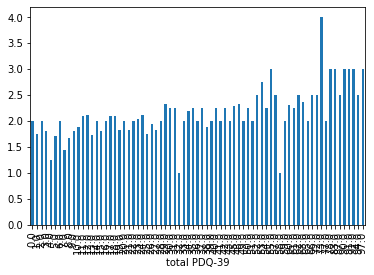

5


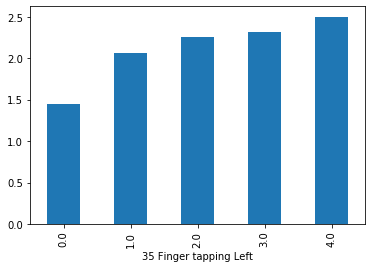

5


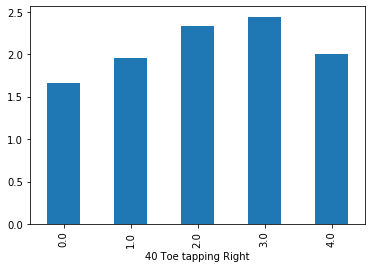

4


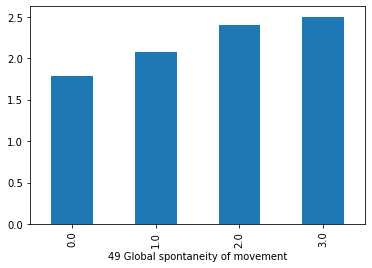

27


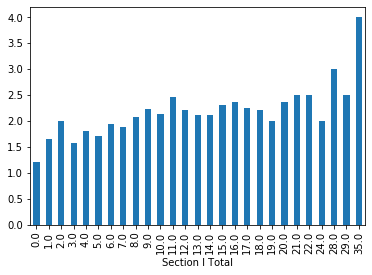

5


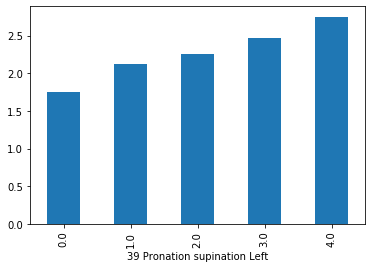

5


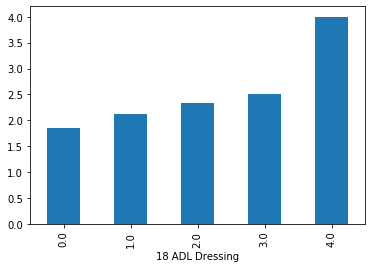

5


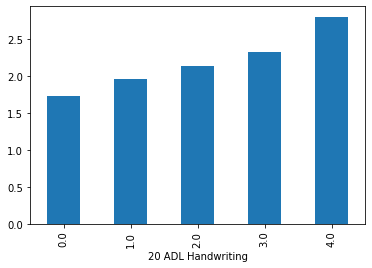

,var,corr
65,Hoehn and Yahr,1.000000
125,UDPRS_Tot,0.718389
73,Section III Total,0.658080
42,47 Postural stability,0.650852
72,Section II Total,0.587773
...,...,...
90,MMSE result,-0.143862
106,MoCA Recall,-0.150916
112,MoCA trails,-0.153712
109,MoCA Total,-0.173332


In [454]:
correlations(udprs_cog_moc,clustervars2,'Hoehn and Yahr',plot=0,corr_thresh=0.1)

In [465]:
mod_data_simp=udprs_cog_moc[['SYDID','Section II Total','Section III Total','tremor','non_tremor','FOGQ 3',
                             'Section IV Total','MMSE result','MoCA Total','total PDQ-39','DDE','Hoehn and Yahr']]

for col in mod_data_simp.columns:
    mod_data_simp=mod_data_simp[(mod_data_simp[col]!=999)]
mod_data_simp.shape

(266, 12)

In [467]:
import umap

Series.base is deprecated and will be removed in a future version


[01:00:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.3656413224567944


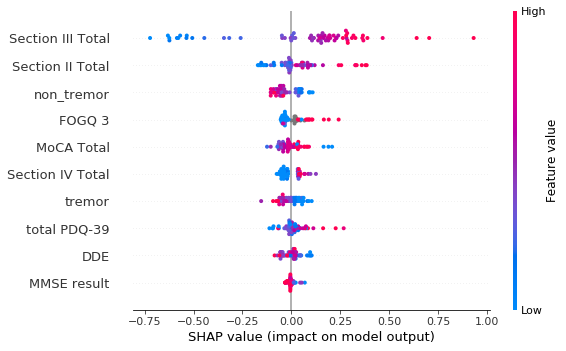

In [466]:
modfit=model_fit(mod_data_simp,'Hoehn and Yahr')

In [398]:
udprs_cog_moc=pd.read_csv('%s%s' % (outdata,'udprs_cog_moc.csv'))

In [401]:
from scipy.stats import pearsonr
# seed random number generator

# calculate Pearson's correlation


In [ ]:
correlations(udprs_cog_moc,)

Unnamed: 0
104.61068702290076



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


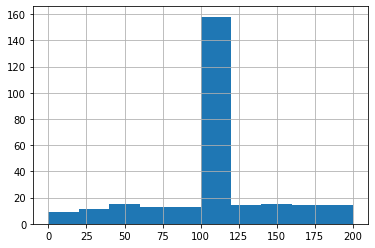

(145,)
1 Cognitive impairment
0.8514492753623188



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


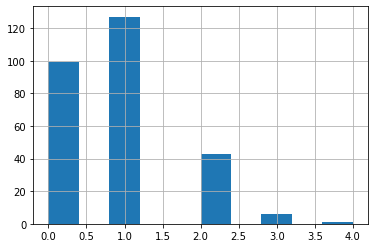

(0,)
10 Urinary problems
1.0543478260869565


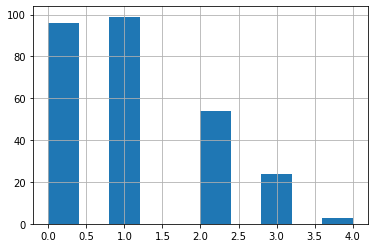

(0,)
11 Constipation problems
0.9166666666666666


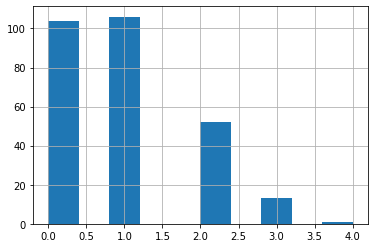

(0,)
12 Light headedness on standing
0.5108695652173914


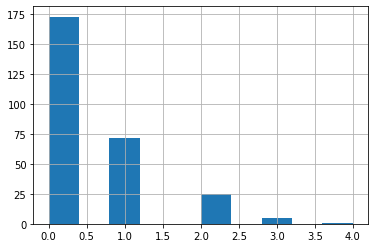

(0,)
13 Fatigue
0.927536231884058


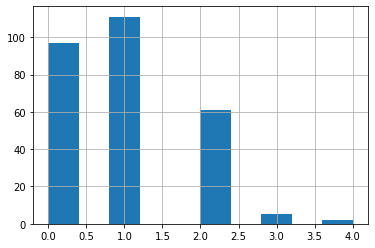

(0,)
14 ADL Speech
0.9927536231884058


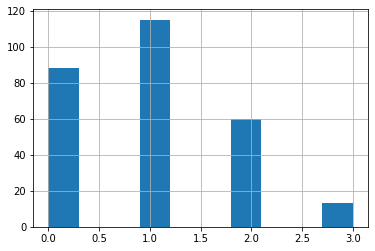

(0,)
15 ADL Saliva and drooling
1.1992753623188406


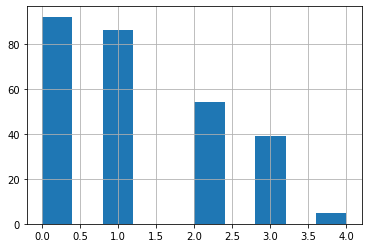

(0,)
16 ADL Chewing and swallowing
0.6413043478260869


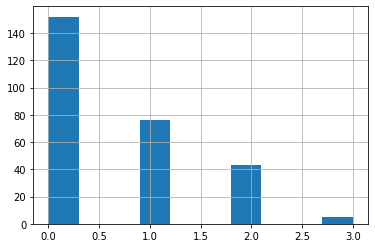

(0,)
17 ADL Eating tasks
0.6195652173913043


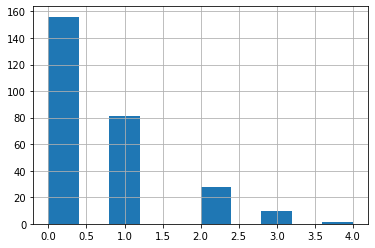

(0,)
18 ADL Dressing
0.8043478260869565


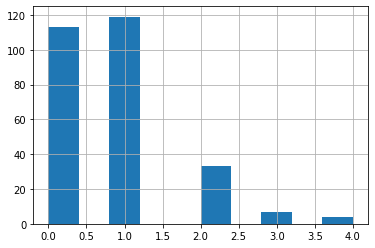

(0,)
19 ADL Hygiene
0.5398550724637681


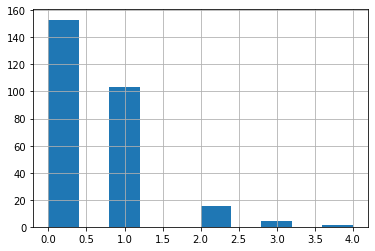

(0,)
2 Hallucinations and Psychosis
0.48188405797101447


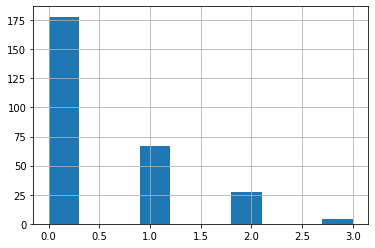

(0,)
20 ADL Handwriting
1.5036231884057971


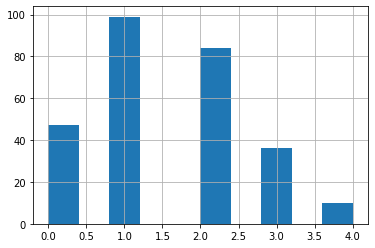

(0,)
21 ADL Hobbies
0.7137681159420289


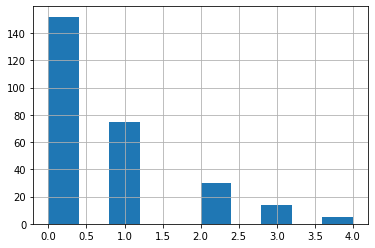

(0,)
22 ADL Turning in bed
0.8115942028985508


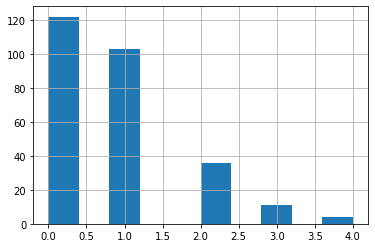

(0,)
23 ADL Tremor
0.9456521739130435


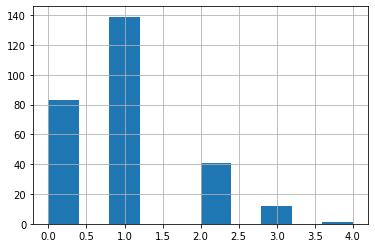

(0,)
24 ADL Getting out of bed
0.717391304347826


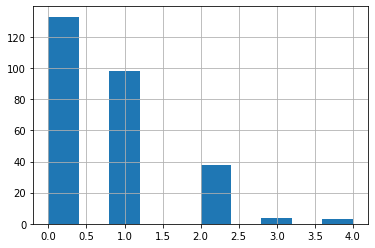

(0,)
25 ADL Walking and balance
1.0615942028985508


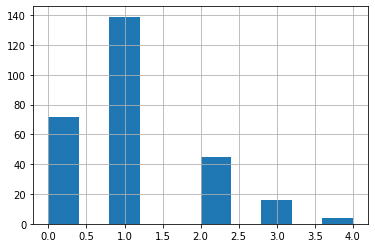

(0,)
26 ADL Freezing
0.4673913043478261


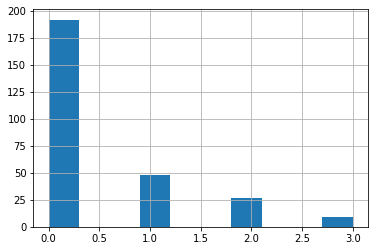

(0,)
27 Motor speech
0.9166666666666666


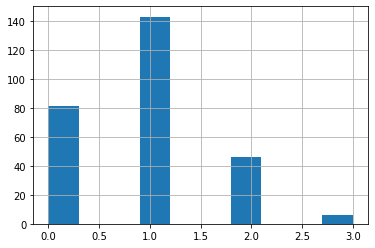

(0,)
28 Facial expression
1.0797101449275361


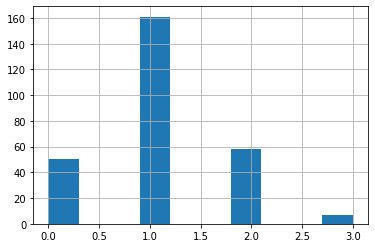

(0,)
29 Rigidity Neck
0.927536231884058


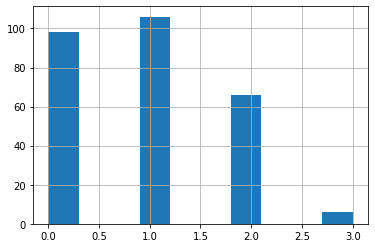

(0,)
3 Depressed mood
0.6304347826086957


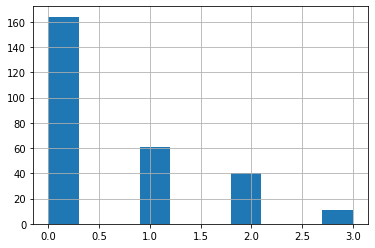

(0,)
30 Rigidity Right Arm
1.3695652173913044


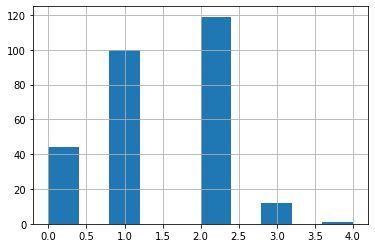

(0,)
31 Rigidity Left Arm
1.1485507246376812


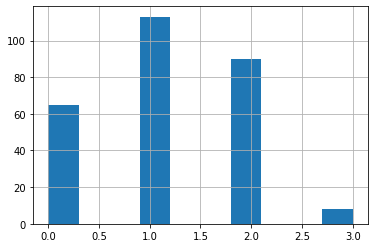

(0,)
32 Rigidity Right Leg
0.8043478260869565


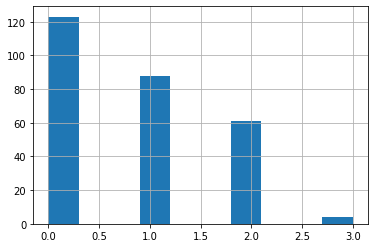

(0,)
33 Rigidity Left Leg
0.7862318840579711


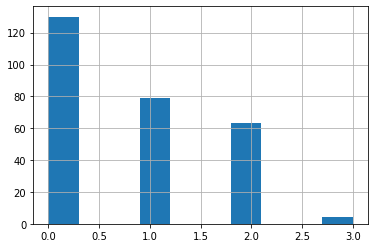

(0,)
34 Finger tapping Right
1.434782608695652


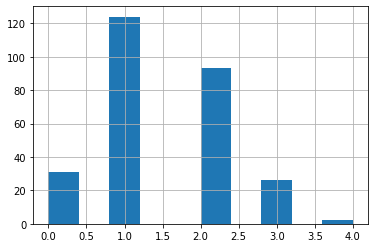

(0,)
35 Finger tapping Left
1.4275362318840579


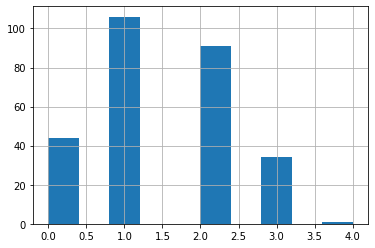

(0,)
36 Hand Movements Right
1.4021739130434783


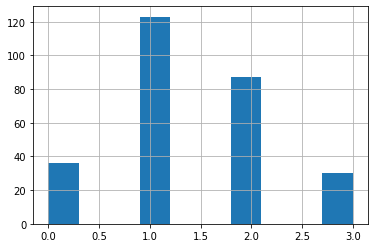

(0,)
37 Hand Movements Left
1.4456521739130435


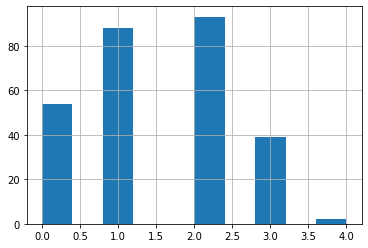

(0,)
38 Pronation supination Right
0.9528985507246377


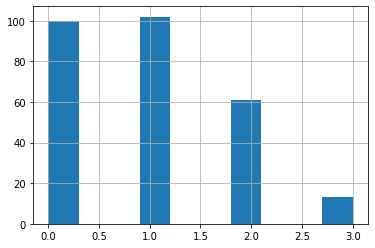

(0,)
39 Pronation supination Left
1.0434782608695652


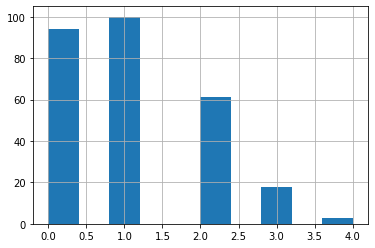

(0,)
4 Anxious mood
0.605072463768116


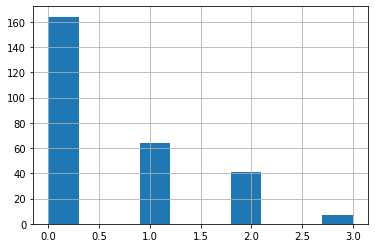

(0,)
40 Toe tapping Right
1.318840579710145


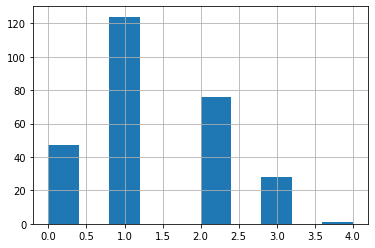

(0,)
41 Toe tapping Left
1.4202898550724639


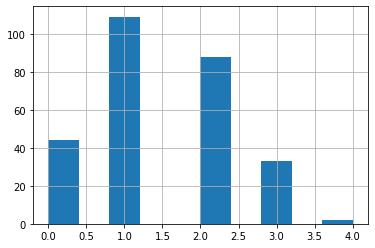

(0,)
42 Leg agility Right
0.8623188405797102


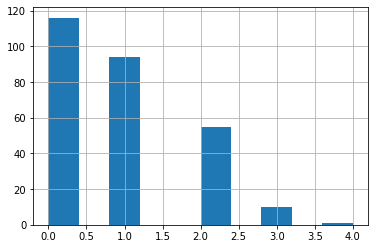

(0,)
43 Leg agility Left
0.9384057971014492


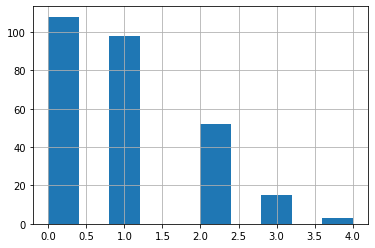

(0,)
44 Arising from chair
0.4057971014492754


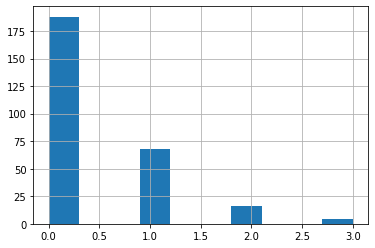

(0,)
45 Gait
1.1485507246376812


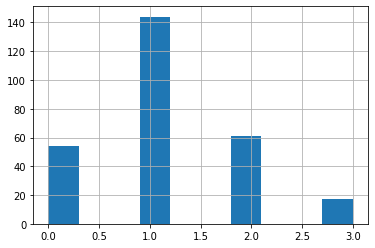

(0,)
46 Freezing of gait
0.2971014492753623


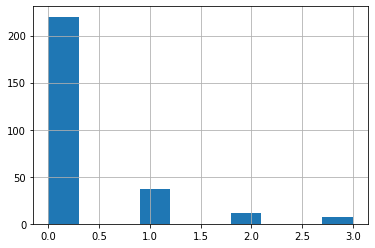

(0,)
47 Postural stability
0.5543478260869565


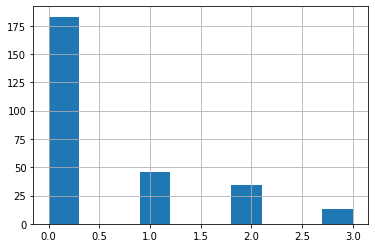

(0,)
48 Posture
0.7862318840579711


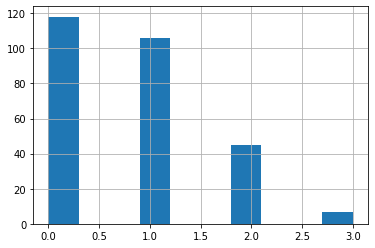

(0,)
49 Global spontaneity of movement
0.927536231884058


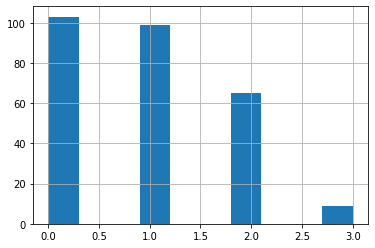

(0,)
5 Apathy
0.39855072463768115


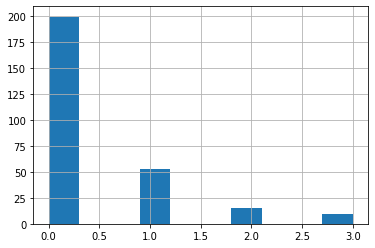

(0,)
50 Postural tremor Right Arm
0.572463768115942


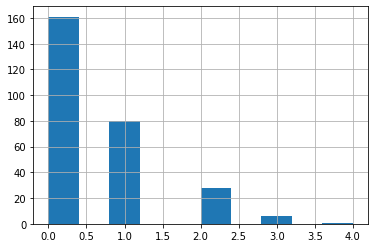

(0,)
51 Postural tremor Left Arm
0.5579710144927537


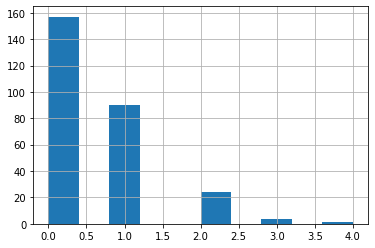

(0,)
52 Kinetic tremor Right Hand
0.2753623188405797


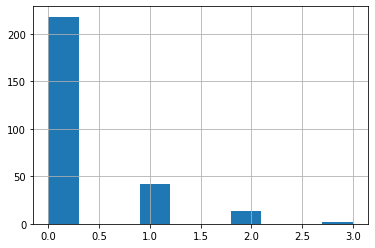

(0,)
53 Kinetic tremor Left Hand
0.358695652173913


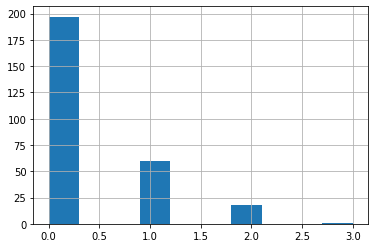

(0,)
54 Rest tremorAmplitude Right Arm
0.5507246376811594


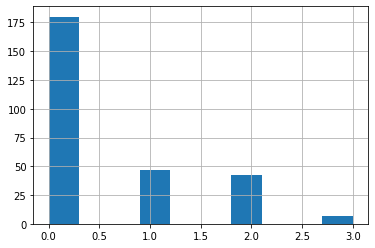

(0,)
55 Rest tremorAmplitude Left Arm
0.4528985507246377


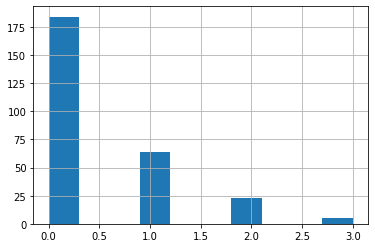

(0,)
56 Rest tremorAmplitude Right Leg
0.13043478260869565


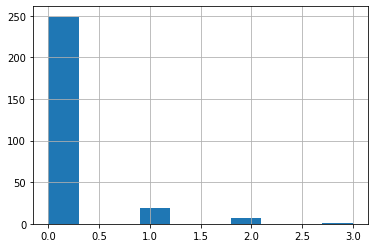

(0,)
57 Rest tremorAmplitude Left Leg
0.09782608695652174


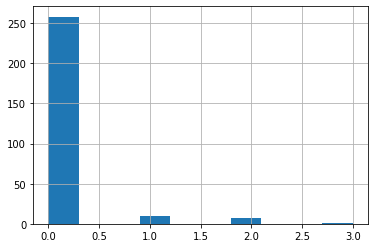

(0,)
57a Rest Tremor Amplitude Jaw/Lip
0.08333333333333333


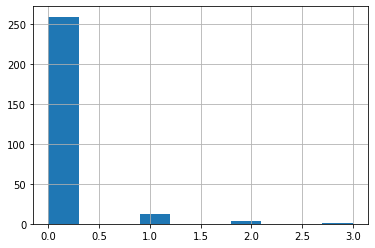

(0,)
58 Constancy of Rest Tremor
0.6521739130434783


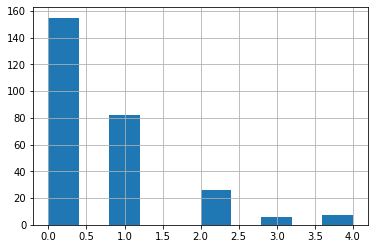

(0,)
6 Features of DDS
0.17391304347826086


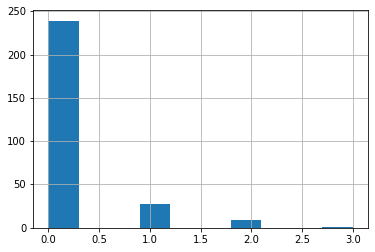

(0,)
7 Sleep problems
1.358695652173913


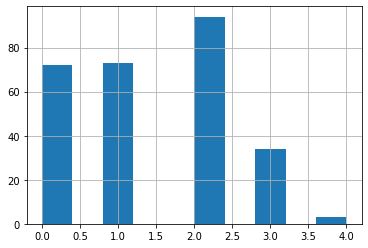

(0,)
8 Daytime sleepiness
1.0072463768115942


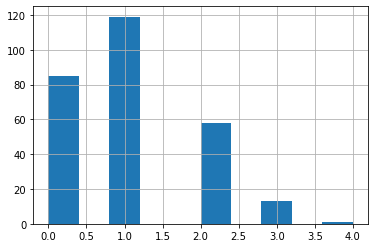

(0,)
9 Pain and other sensations
0.6630434782608695


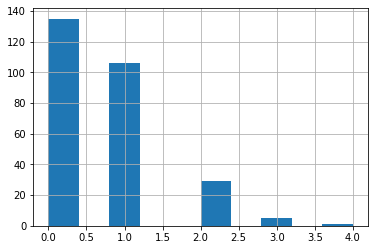

(0,)
Clinical state
DDE
78.37142857142857


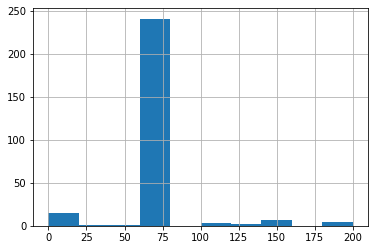

(240,)
Date of assessment
Dyskinesias interfered with rating
0.03260869565217391


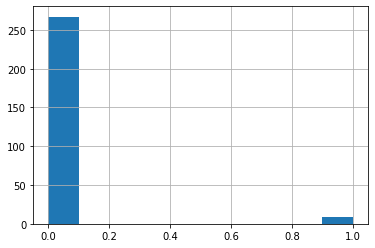

(0,)
Dyskinesias present
0.12681159420289856


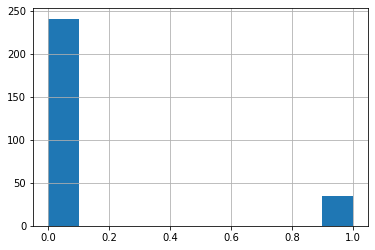

(0,)
Filling in questionnaire
Functional impact of Dyskinesia
0.2246376811594203


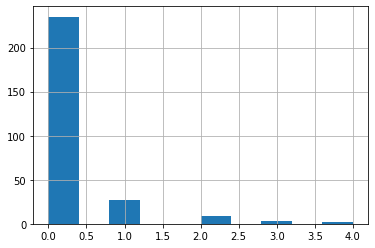

(0,)
Functional impact of Fluctuations
0.36231884057971014


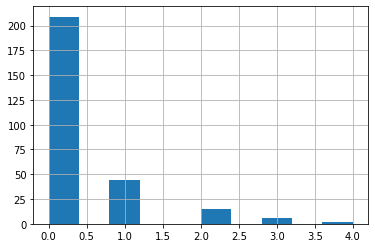

(0,)
Hoehn and Yahr
2.0778985507246377


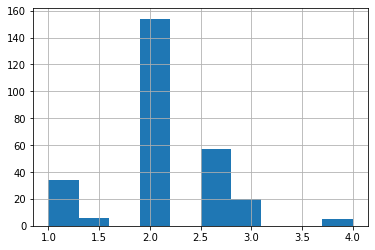

(0,)
Minutes since last dose
94.25728155339806


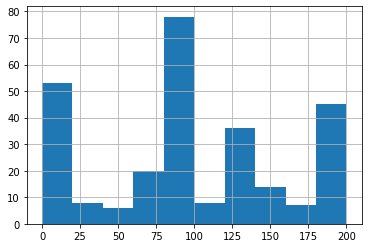

(69,)
On L-dopa
0.8514492753623188


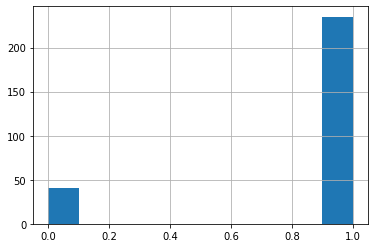

(0,)
On medication
0.9166666666666666


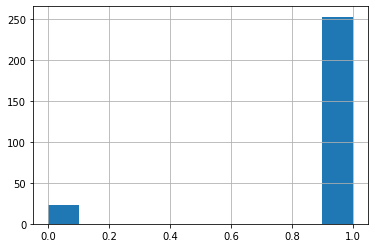

(0,)
Painful Off Dystonias
0.23550724637681159


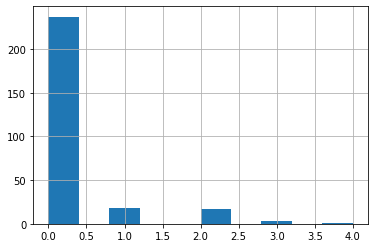

(0,)
Predictability of fluctuations
0.2826086956521739


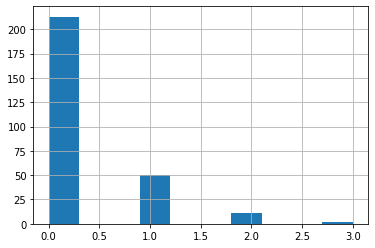

(0,)
SYDID
Scwab and Eng (rater)
0.0


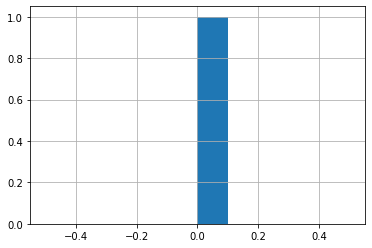

(0,)
Scwab and Eng (subject)
0.0


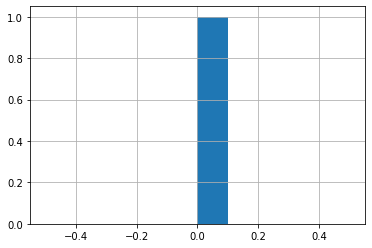

(0,)
Section I Total
9.579710144927537


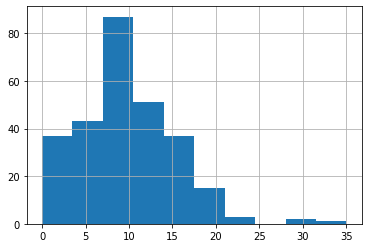

(0,)
Section II Total
11.018115942028986


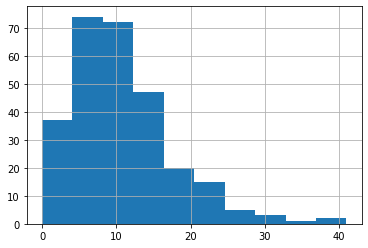

(0,)
Section III Total
27.130434782608695


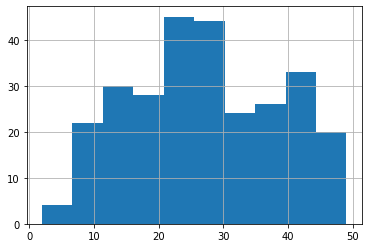

(0,)
Section IV Total
1.684782608695652


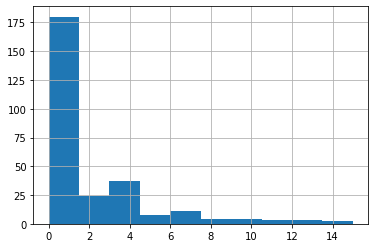

(0,)
Source
Time spent in Off
0.2753623188405797


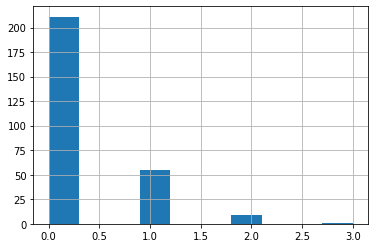

(0,)
Time spent with Dyskinesia
0.30434782608695654


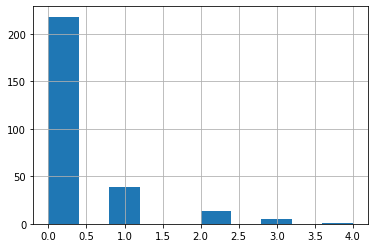

(0,)
Timed hand tapping test-right
0.07636363636363637


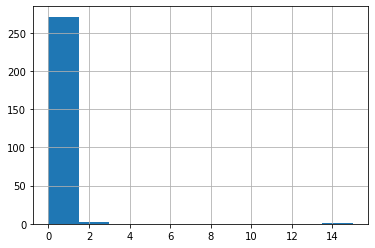

(0,)
recs_x
4.557971014492754


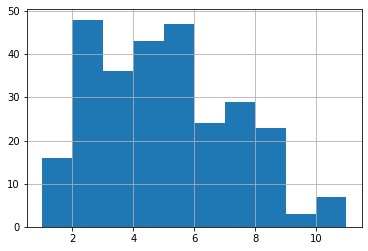

(0,)
num_timepoints_x
Date
ONOFF
AGE
64.3972602739726


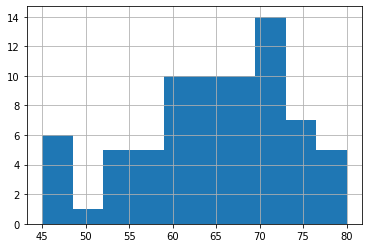

(0,)
AGE GROUP
ASS %
11.915750915750916


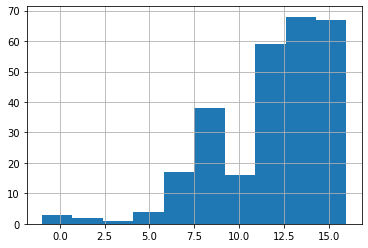

(2,)
ASS 1
10.856617647058824


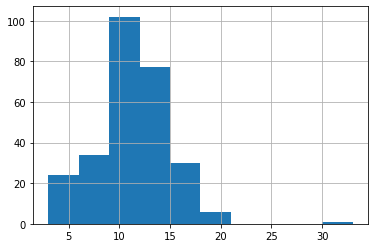

(2,)
ASS 2
11.512820512820513


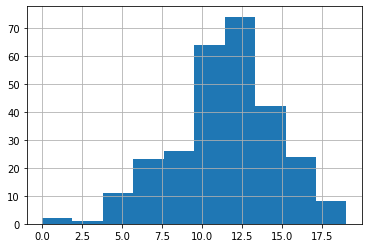

(2,)
Age
65.29457364341086


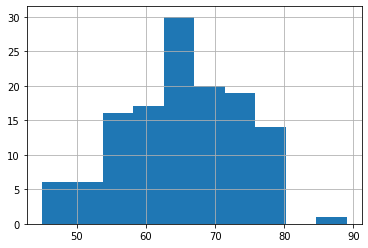

(0,)
Age 
66.63513513513513


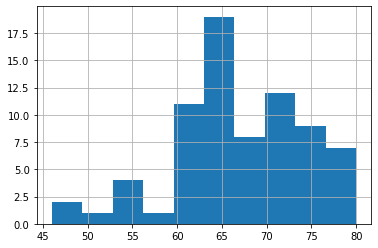

(0,)
Age group
Age grpup
Date/time
Digit Span
nan


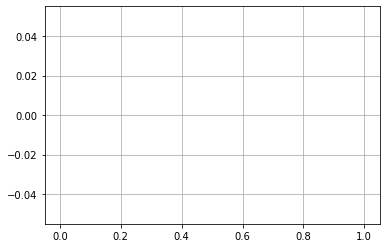

(0,)
Digit Span - Backward
6.5787545787545785


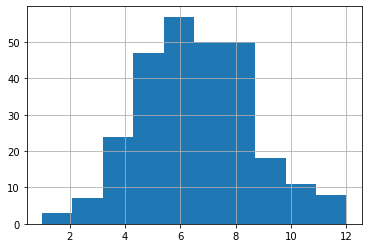

(2,)
Digit Span - Forward
10.413919413919414


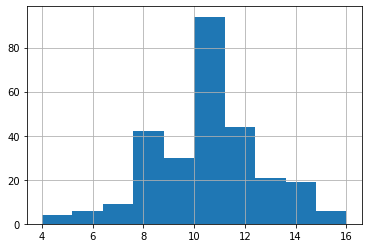

(2,)
Digit Span ASS
10.934065934065934


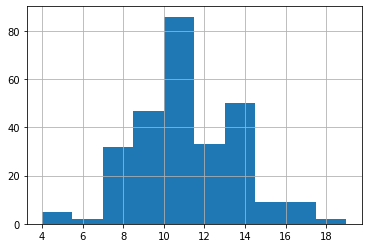

(2,)
Digit Span Total
16.992673992673993


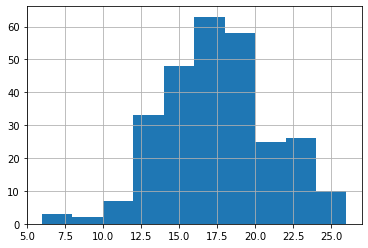

(2,)
LM % Retention
81.12820512820512


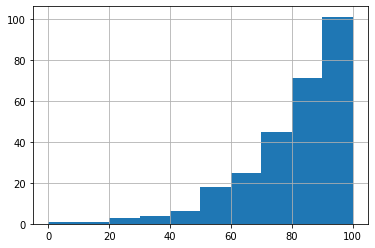

(2,)
LM Recognition
26.04201680672269


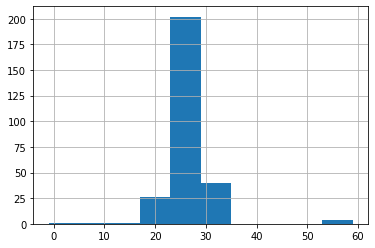

(37,)
Logical Memory I
37.989010989010985


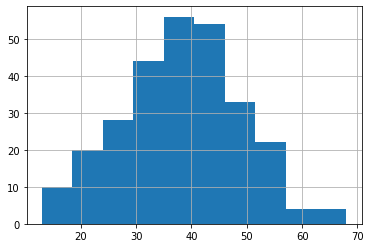

(2,)
Logical Memory II
23.128205128205128


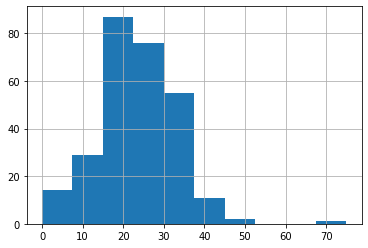

(2,)
MMSE result
28.481884057971016


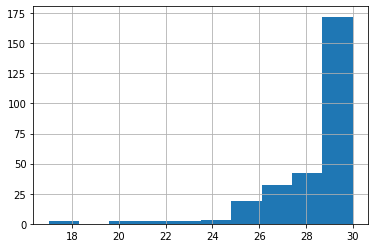

(0,)
NART
109.49814126394052


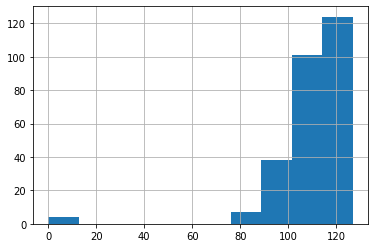

(5,)
Stroop  1 raw
34.5625


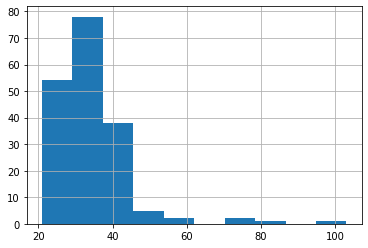

(5,)
Stroop 1 ASS
9.403409090909092


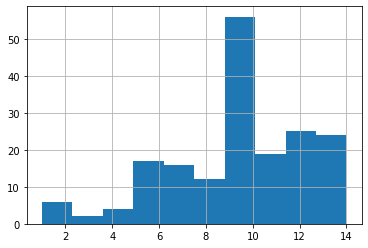

(5,)
Stroop 2 ASS
10.409090909090908


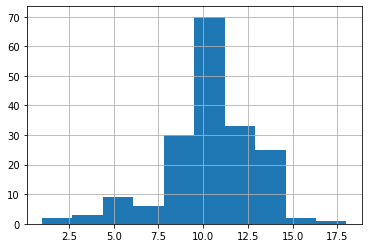

(5,)
Stroop 2 raw
24.17142857142857


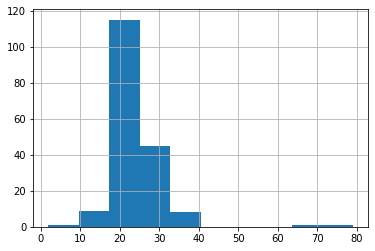

(5,)
Stroop 3 ASS
10.722543352601155


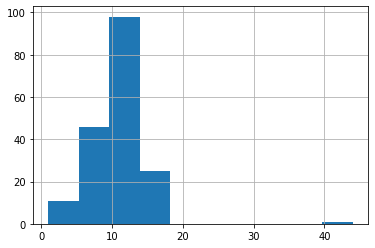

(8,)
Stroop 3 raw
66.64739884393063


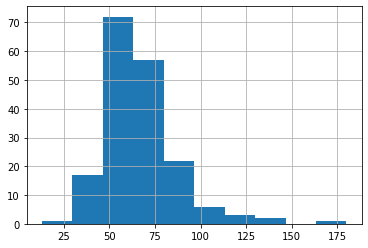

(8,)
Stroop 4 ASS
10.94767441860465


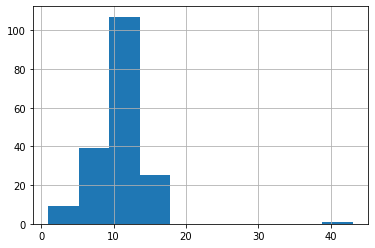

(9,)
Stroop 4 raw
71.49418604651163


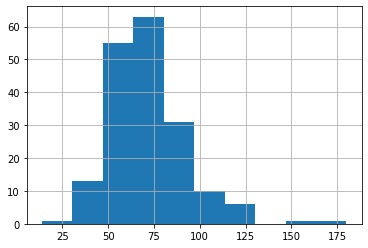

(9,)
Trails A Errors
0.1213235294117647


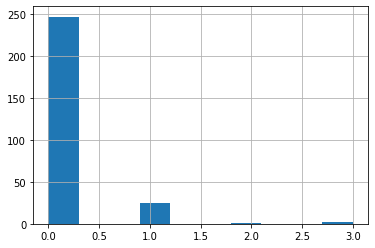

(3,)
Trails A Time
39.34065934065934


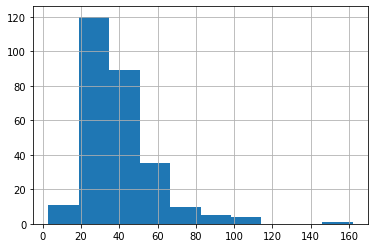

(2,)
Trails A Z score
0.25805860805860775


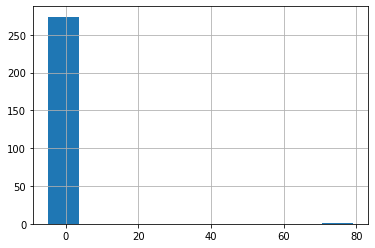

(2,)
Trails B Errors
1.1970260223048328


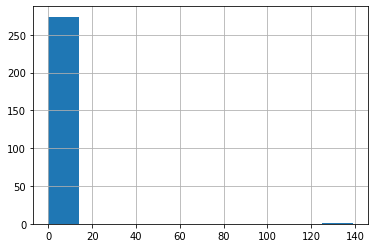

(6,)
Trails B Time
84.31640625


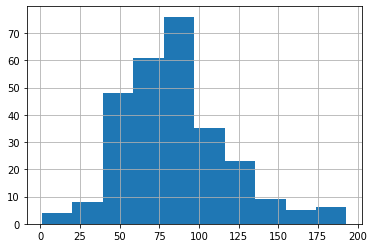

(19,)
Trails B Z score
-0.03956666666666668


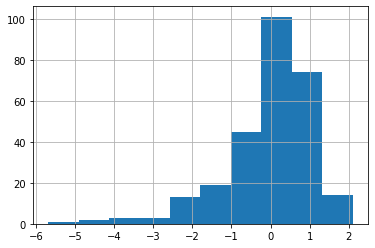

(5,)
Verbal fluency-animals
0.22753479853479852


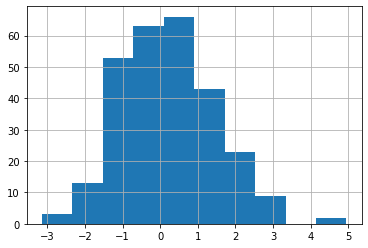

(2,)
Verbal fluency-letters
0.1320659340659341


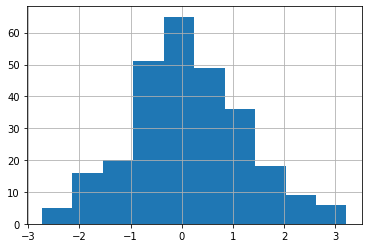

(2,)
Years of education
14.402173913043478


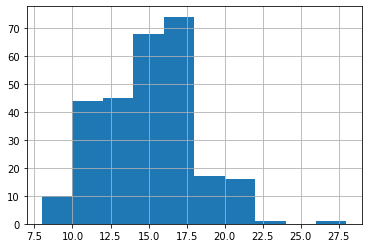

(0,)
index
102.31627906976745



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


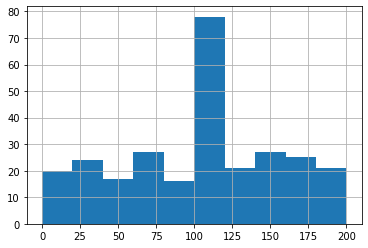

(61,)
time_point
0.6594202898550725



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


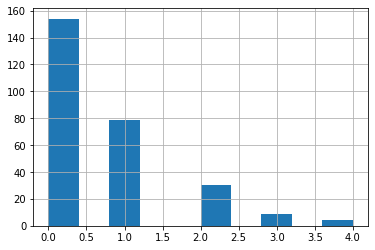

(0,)
Gend
Birth_date
Princ_Diag
Date Diagnosed
recs_y
4.492753623188406


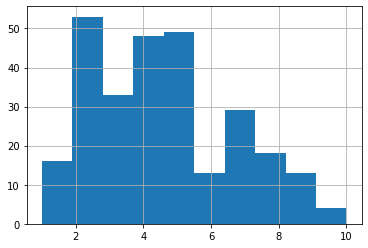

(0,)
num_timepoints_y
MoCA Fluency
0.8115942028985508


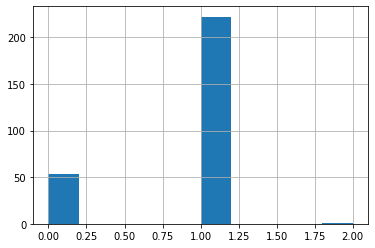

(0,)
MoCA Orientation
5.804347826086956


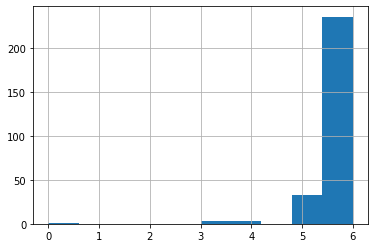

(0,)
MoCA Recall
3.079710144927536


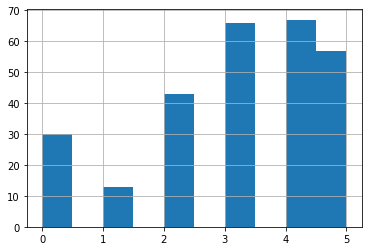

(0,)
MoCA Repetition
1.7282608695652173


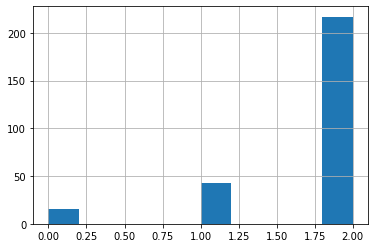

(0,)
MoCA Serial 7s
2.8043478260869565


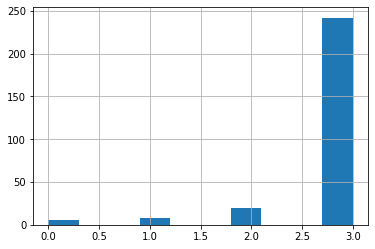

(0,)
MoCA Total
26.75


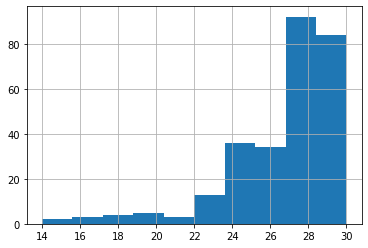

(0,)
MoCA digits backwards
0.9528985507246377


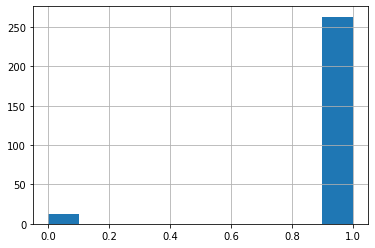

(0,)
MoCA digits forwards
0.9818840579710145


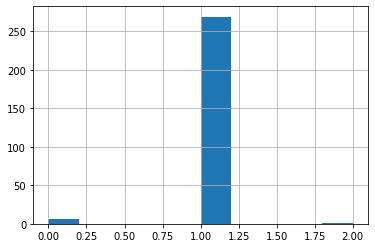

(0,)
MoCA trails
Date FOGQ
FOGQ 1
1.4343434343434343


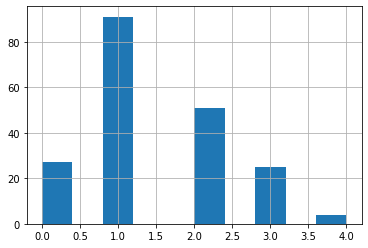

(0,)
FOGQ 2
0.7878787878787878


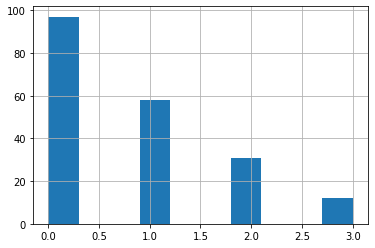

(0,)
FOGQ 3
0.9696969696969697


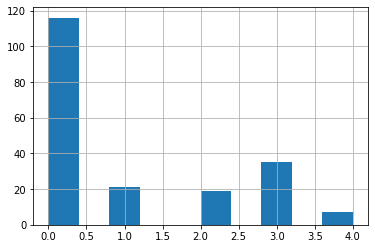

(0,)
FOGQ 4
0.6515151515151515


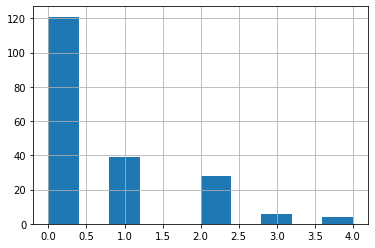

(0,)
FOGQ 5
0.5505050505050505


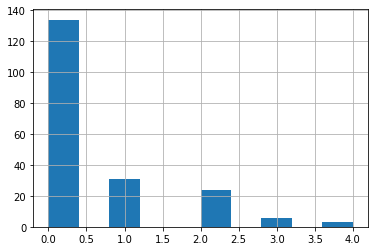

(0,)
FOGQ 6
0.4595959595959596


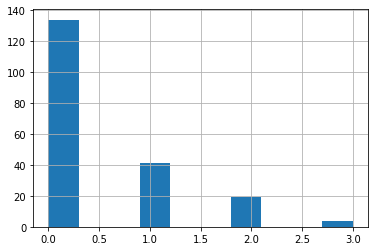

(0,)
FOGQ Total
4.853535353535354


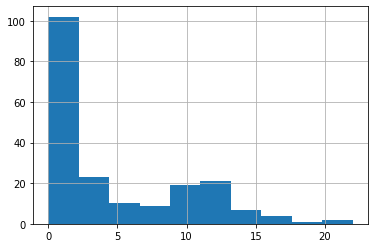

(0,)
recs
4.393939393939394


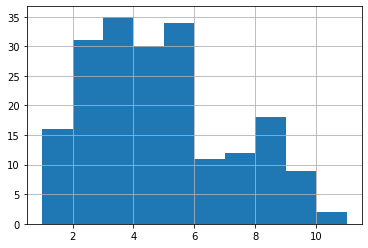

(0,)
num_timepoints
total PDQ-39
30.282608695652176


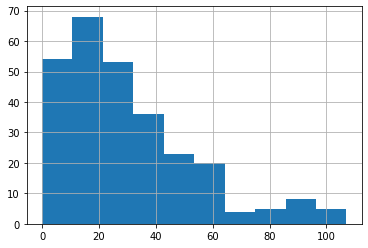

(0,)
Rigidity_Arm
1.608695652173913


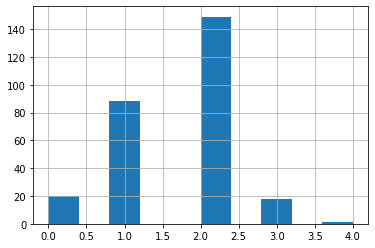

(0,)
Rigidity_Leg
0.9927536231884058


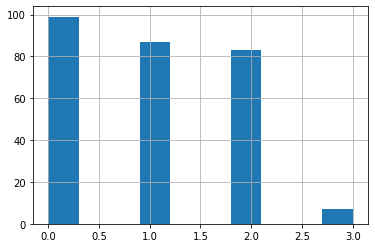

(0,)
Finger tapping
1.7427536231884058


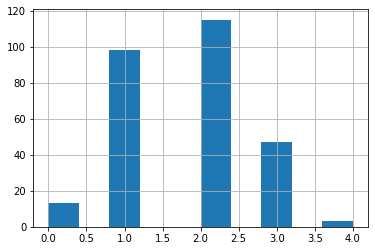

(0,)
Hand Movements
1.7355072463768115


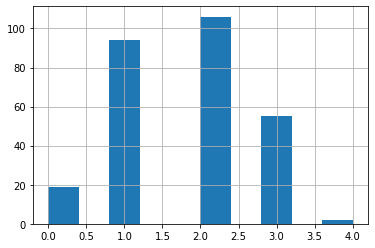

(0,)
Pronation supination
1.2282608695652173


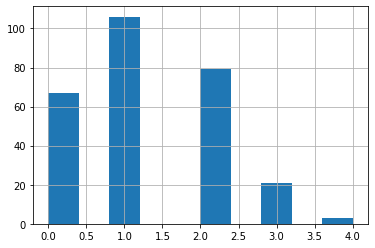

(0,)
Toe tapping
1.6956521739130435


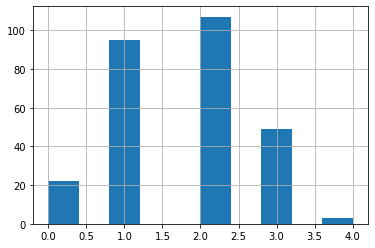

(0,)
Leg Agility
1.105072463768116


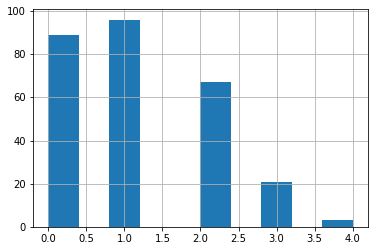

(0,)
Rest tremorAmplitude Arm
0.8297101449275363


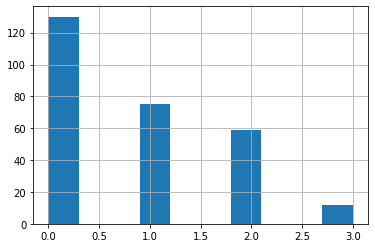

(0,)
Rest tremorAmplitude Leg
0.19202898550724637


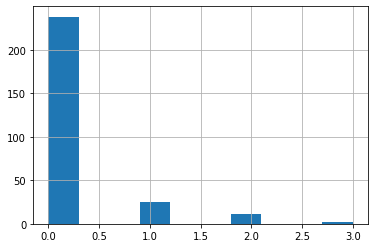

(0,)
non_tremor
1.2521739130434786


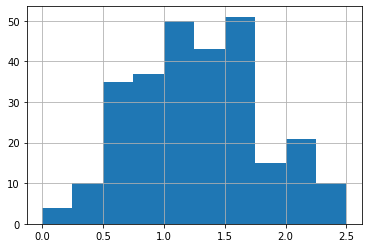

(0,)
tremor
0.5405797101449274


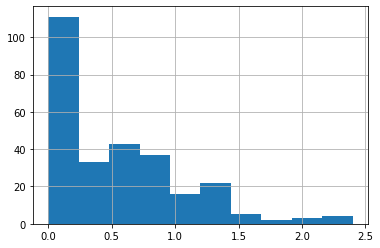

(0,)
tremor_ratio
0.506479411038755


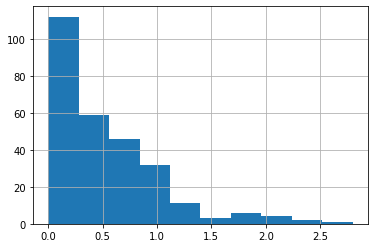

(1,)
UDPRS_Tot
47.72826086956522


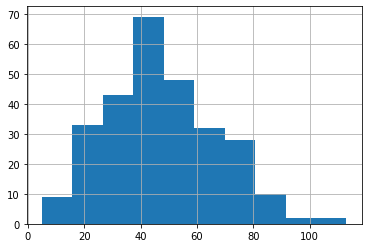

(0,)
Disease_Duration
17.714285714285715



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


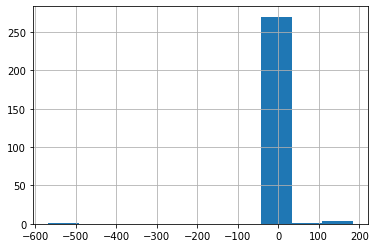

(269,)
first_date_assessment
time_since_first
7.734939759036145



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


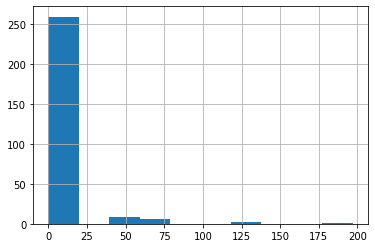

(110,)
Age_Diagnosis
59.25894513386699



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


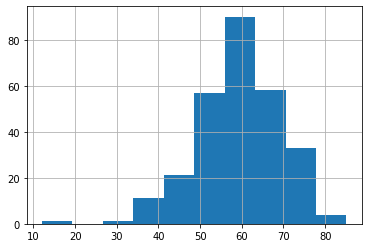

(0,)
Disease_Progression
0.07147689617598801


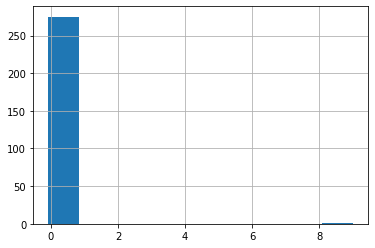

(0,)
pct_chgtremor
0.12409128882813093


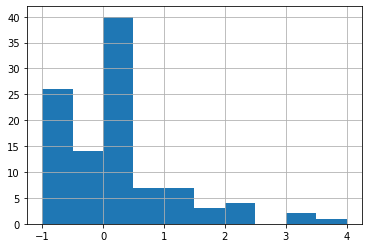

(9,)
chg_tremor
0.008196721311475405


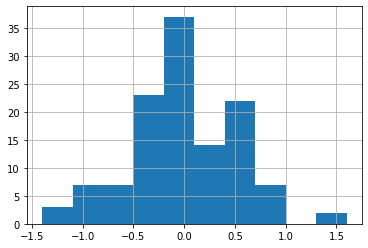

(0,)
pct_chgnon_tremor
0.17009676142993407


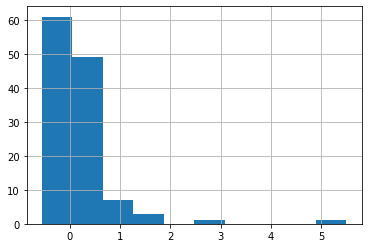

(0,)
chg_non_tremor
0.08606557377049183


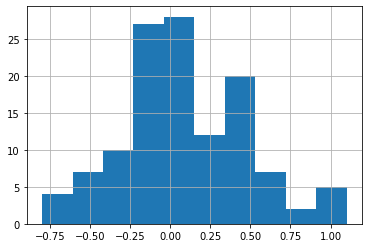

(0,)
pct_chgUDPRS_Tot
0.14720671299794535


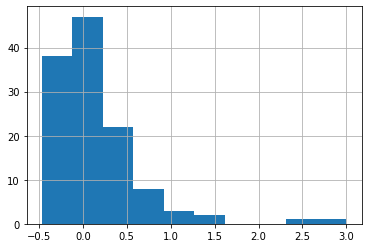

(0,)
chg_UDPRS_Tot
2.7131147540983607


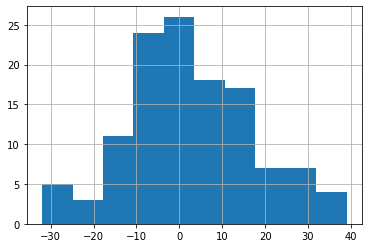

(0,)
pct_chgSectionITotal
0.05242418401191854


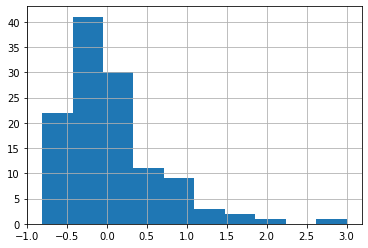

(2,)
chg_SectionITotal
-0.9836065573770492


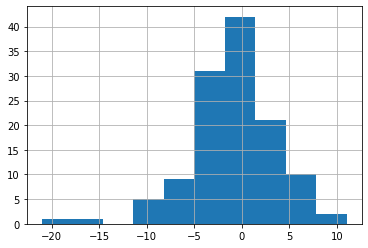

(0,)
pct_chgSectionIITotal
0.24236107959075195


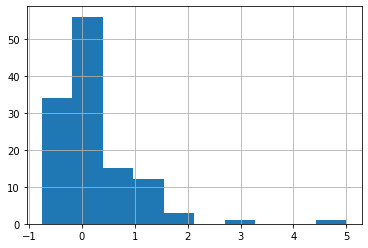

(1,)
chg_SectionIITotal
0.7377049180327869


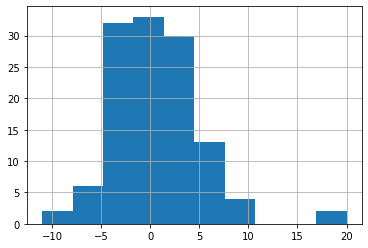

(0,)
pct_chgSectionIIITotal
0.28311237498395736


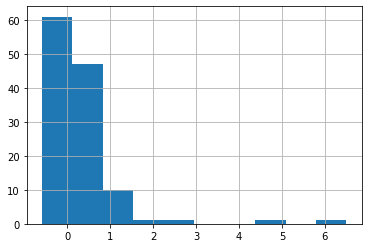

(0,)
chg_SectionIIITotal
2.959016393442623


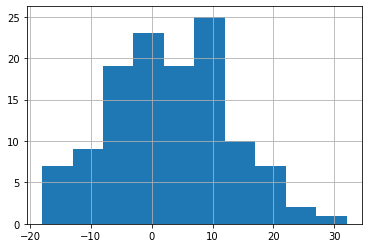

(0,)
pct_chgMMSEresult
0.013516662094289875


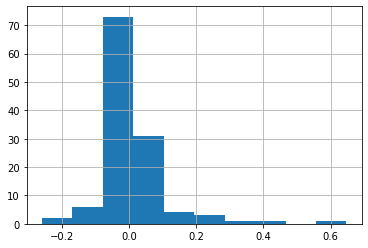

(0,)
chg_MMSEresult
0.22950819672131148


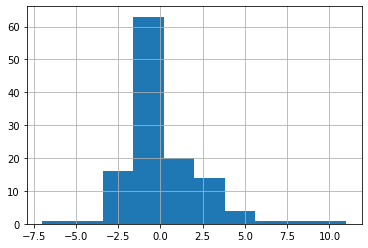

(0,)
pct_chgMoCATotal
0.02706006131839143


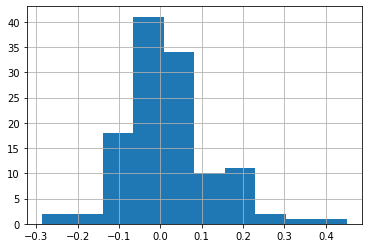

(0,)
chg_MoCATotal
0.5737704918032787


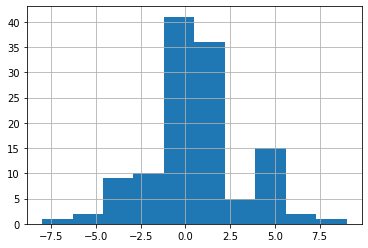

(0,)
tremor_intercept
0.8529092492996407


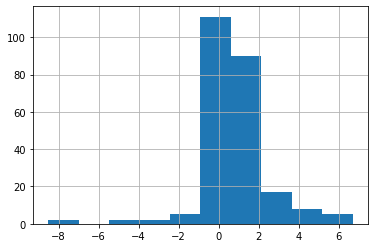

(0,)
tremor_coef
-0.008969646411855627


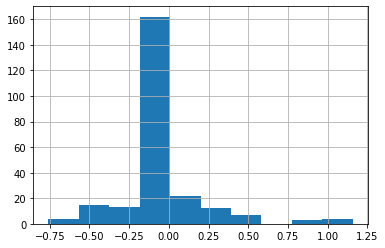

(0,)
tremor_min_date
tremor_max_date
tremor_counts
3.0371900826446283


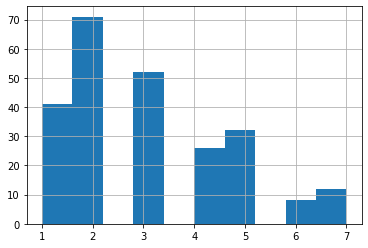

(0,)
non_tremor_intercept
0.802502661281206


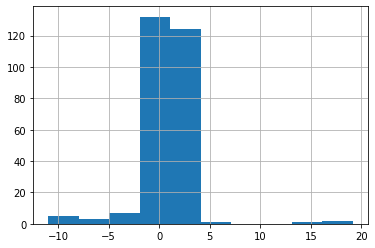

(0,)
non_tremor_coef
0.053858536517258346


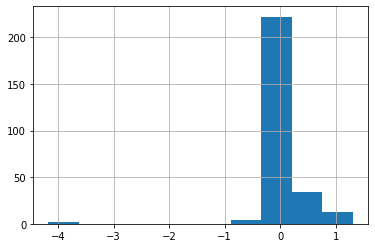

(0,)
non_tremor_min_date
non_tremor_max_date
non_tremor_counts
2.9854545454545454


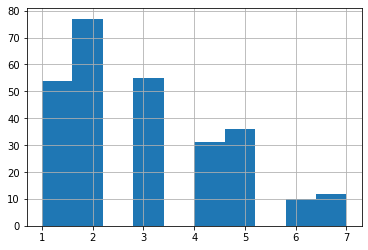

(0,)
UDPRS_Tot_intercept
29.526642123069777


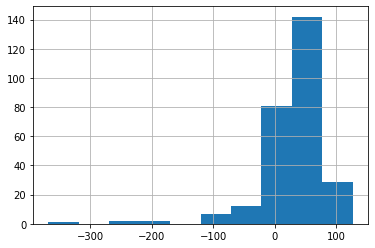

(6,)
UDPRS_Tot_coef
2.3272750657414405


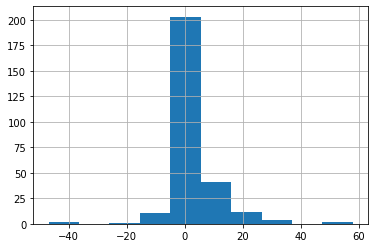

(0,)
UDPRS_Tot_min_date
UDPRS_Tot_max_date
UDPRS_Tot_counts
2.9782608695652173


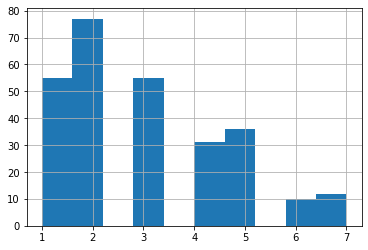

(0,)
SectionITotal_intercept
10.53267361688077


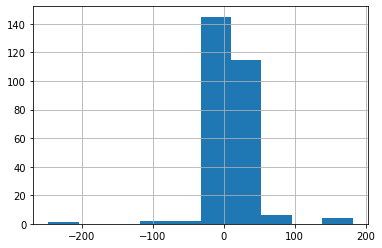

(4,)
SectionITotal_coef
-0.3131466322596411


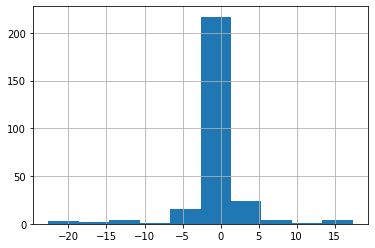

(0,)
SectionITotal_min_date
SectionITotal_max_date
SectionITotal_counts
2.9854545454545454


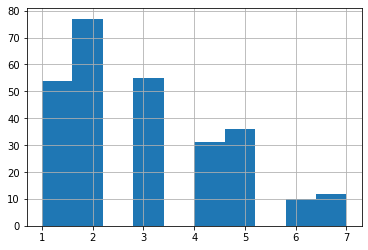

(0,)
SectionIITotal_intercept
6.084831145853094


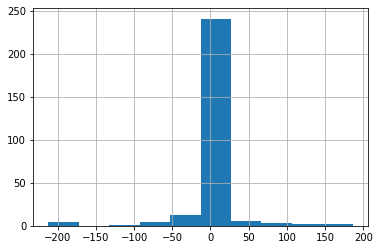

(0,)
SectionIITotal_coef
0.6707809733296579


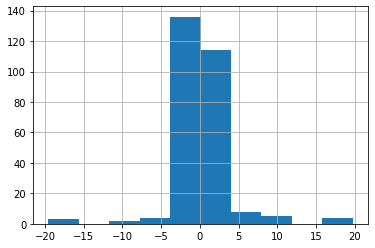

(0,)
SectionIITotal_min_date
SectionIITotal_max_date
SectionIITotal_counts
2.9782608695652173


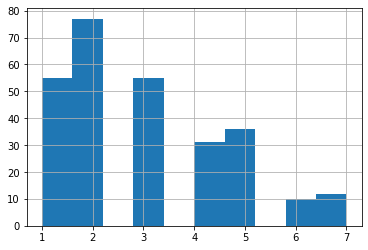

(0,)
SectionIIITotal_intercept
11.631451104214122


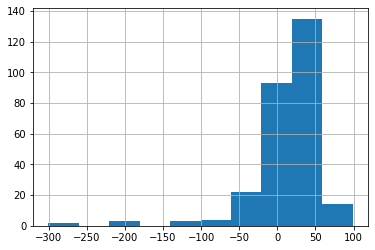

(2,)
SectionIIITotal_coef
1.9310702434614966


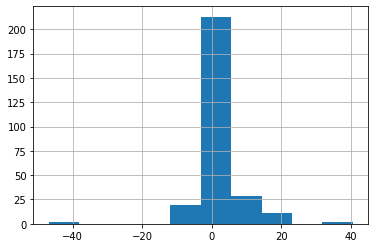

(0,)
SectionIIITotal_min_date
SectionIIITotal_max_date
SectionIIITotal_counts
2.9782608695652173


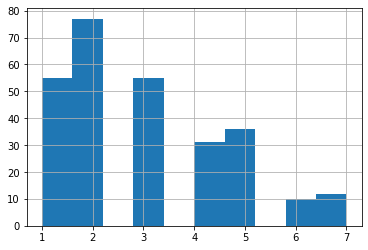

(0,)
MMSEresult_intercept
27.350729725142653


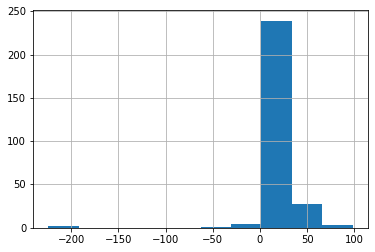

(0,)
MMSEresult_coef
0.21042474711098866


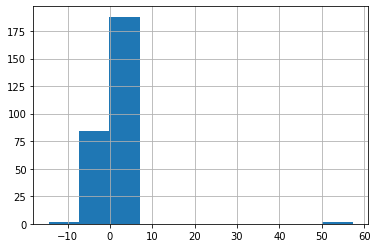

(0,)
MMSEresult_min_date
MMSEresult_max_date
MMSEresult_counts
2.9782608695652173


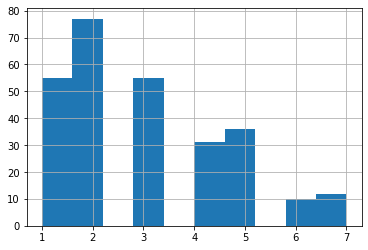

(0,)
MoCATotal_intercept
23.940729929019437


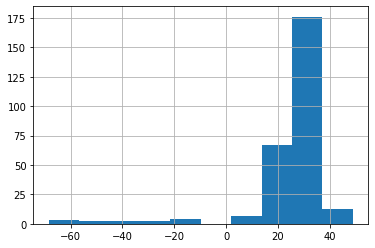

(0,)
MoCATotal_coef
0.03524672001199833


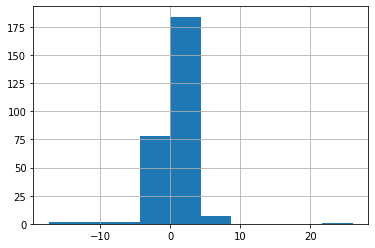

(0,)
MoCATotal_min_date
MoCATotal_max_date
MoCATotal_counts
2.9782608695652173


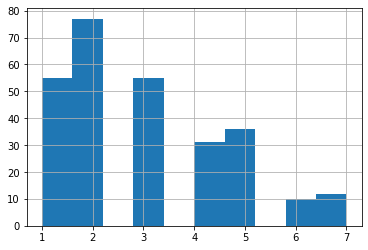

(0,)
chg_MoCATotalsuspect
0.036231884057971016


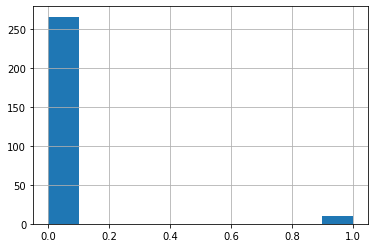

(0,)
chg_MMSEresultsuspect
0.036231884057971016


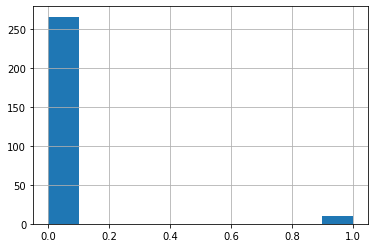

(0,)
chg_UDPRS_Totsuspect
0.050724637681159424


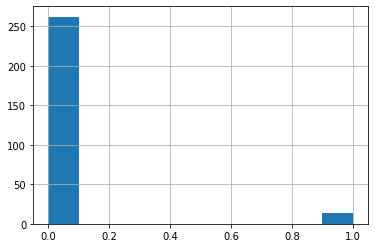

(0,)
chg_maxtremor
0.24524886877828056


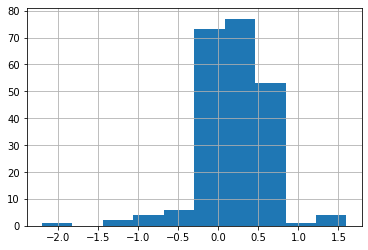

(0,)
chg_mintremor
-0.3457013574660635


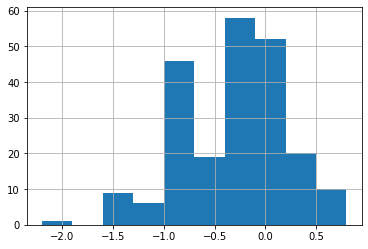

(0,)
chg_maxnon_tremor
0.43516483516483534


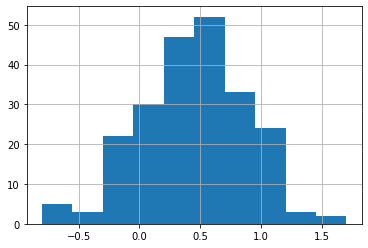

(0,)
chg_minnon_tremor
-0.15736910148674865


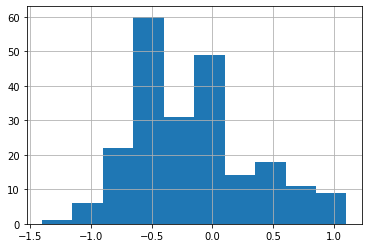

(0,)
chg_maxUDPRS_Tot
14.411764705882353


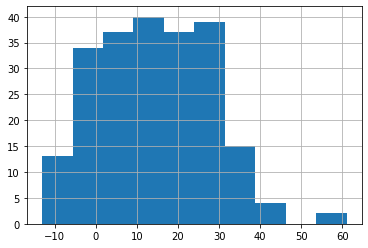

(0,)
chg_minUDPRS_Tot
-4.787330316742081


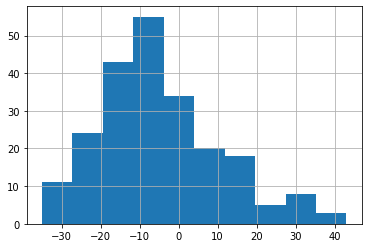

(0,)
chg_maxSectionITotal
2.2986425339366514


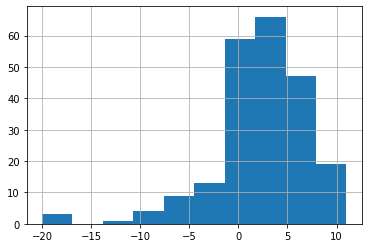

(0,)
chg_minSectionITotal
-3.3438914027149322


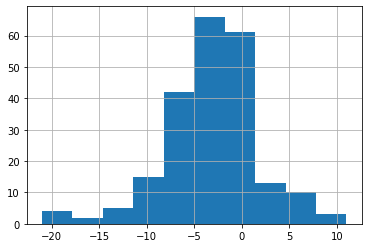

(0,)
chg_maxSectionIITotal
3.918552036199095


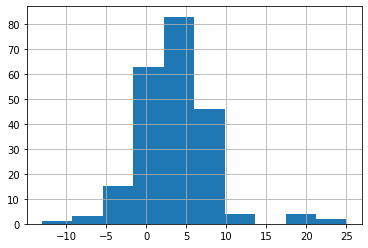

(0,)
chg_minSectionIITotal
-1.2262443438914028


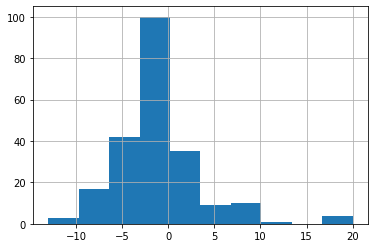

(0,)
chg_maxSectionIIITotal
10.57918552036199


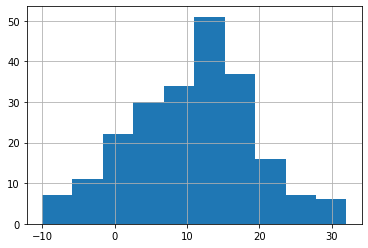

(0,)
chg_minSectionIIITotal
-2.832579185520362


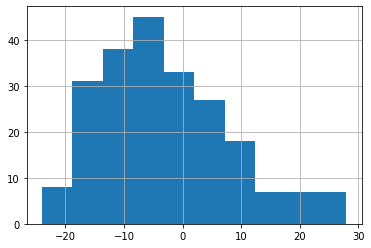

(0,)
chg_maxMMSEresult
1.1719457013574661


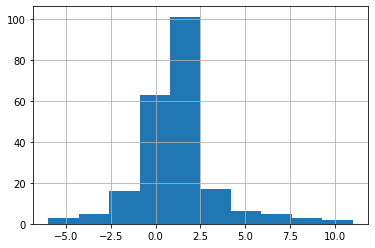

(0,)
chg_minMMSEresult
-1.2126696832579185


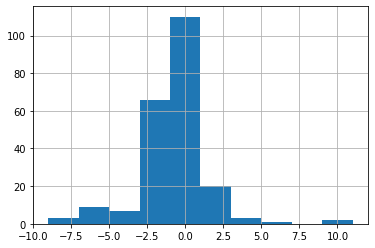

(0,)
chg_maxMoCATotal
1.6108597285067874


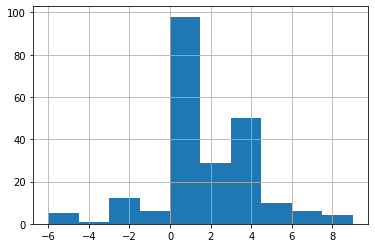

(0,)
chg_minMoCATotal
-1.339366515837104


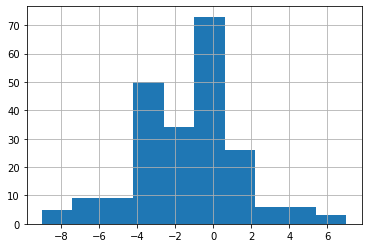

(0,)
latest_rec
1.0


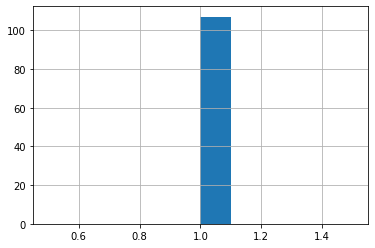

(0,)


In [350]:
mask=pd.notnull(udprs_cog_moc['total PDQ-39'])&(udprs_cog_moc['total PDQ-39']<200)
model_data2=udprs_cog_moc[mask]

for col in model_data2.columns:
    try:
        print(col)

        maskmiss=(model_data2[col]>200)
        mean_score=model_data2[col][~maskmiss].mean()
        print(mean_score)
        model_data2[col][maskmiss]=mean_score
        model_data2[col].hist()
        plt.show()
        print(model_data2[col][maskmiss].shape)
    except:
        pass

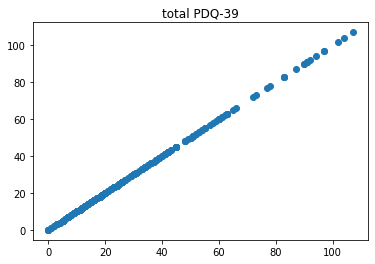

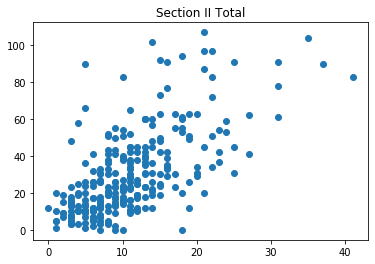

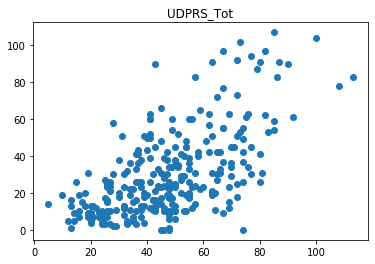

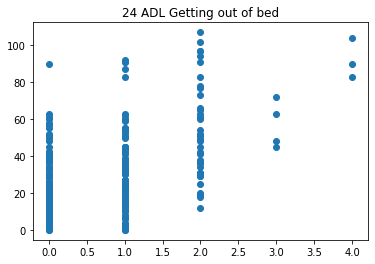

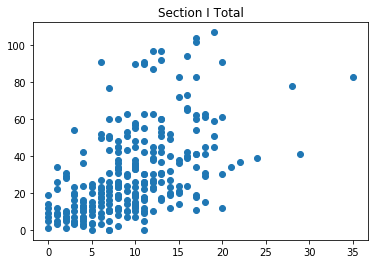

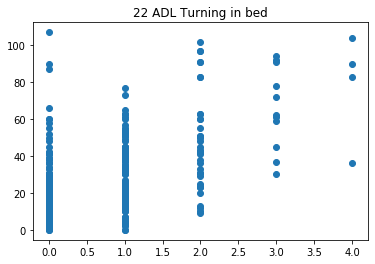

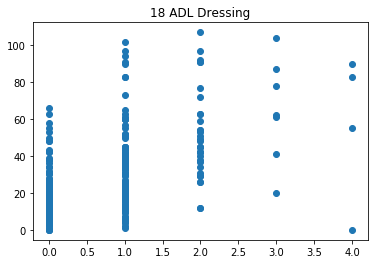

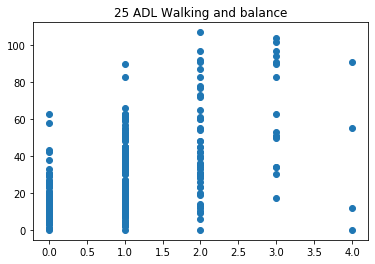

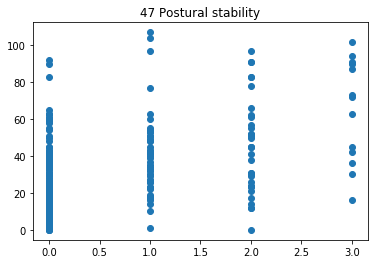

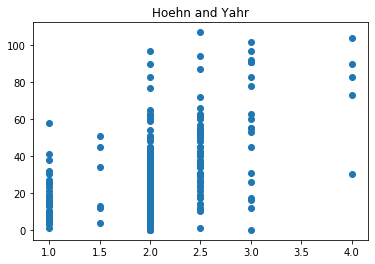

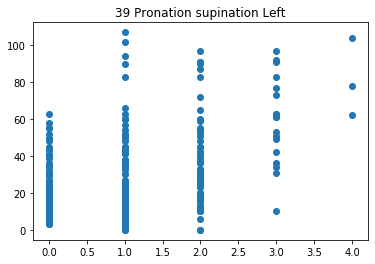

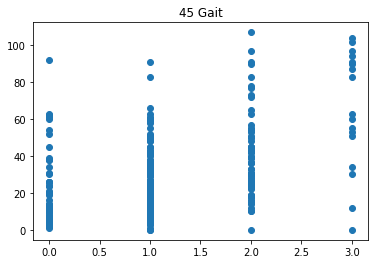

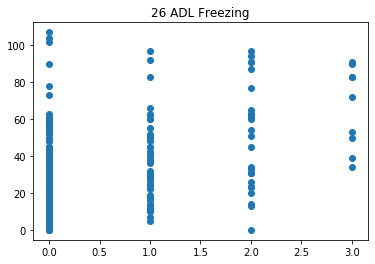

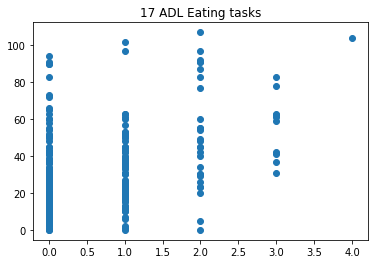

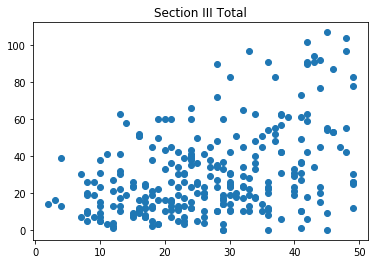

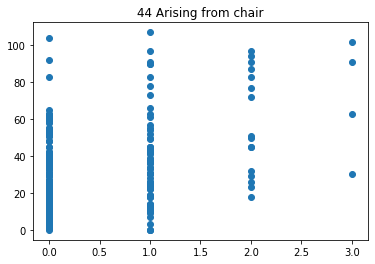

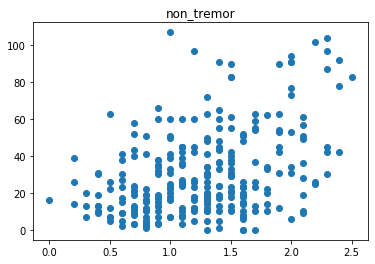

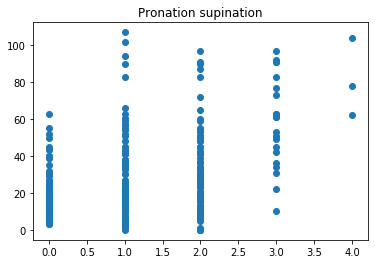

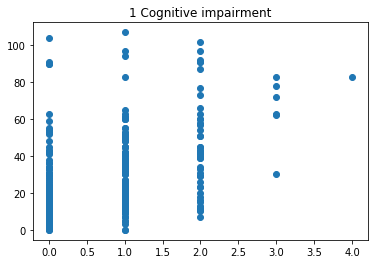

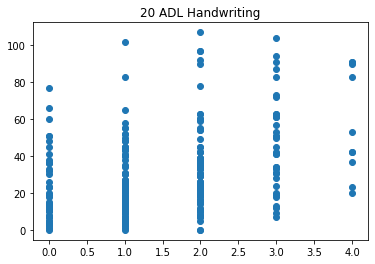

In [369]:
import re


df=correlations(model_data2,clustervars2,depvar='total PDQ-39',plot=0)
df.head(40)

model_data3=model_data2[df['var'].head(30)]

In [370]:
#Seperating the target from the features
X = model_data.drop(['total PDQ-39','SYDID'], axis  = 1)
X = model_data3.drop(['total PDQ-39'], axis  = 1)
#setting y as the target variable
y = model_data['total PDQ-39']
y = model_data3['total PDQ-39']
#Splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 100)

xgr = xgb.XGBRegressor(random_state=42, base_score=0.5)

model = xgb.XGBRegressor(random_state=42, base_score=0.5)
model.fit(X_train,y_train)

[01:25:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Series.base is deprecated and will be removed in a future version


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [373]:
model.score(X_test, y_test)
y_pred = model.predict(X_test)
r2_score(y_pred, y_test)

-0.34784206504773807

197


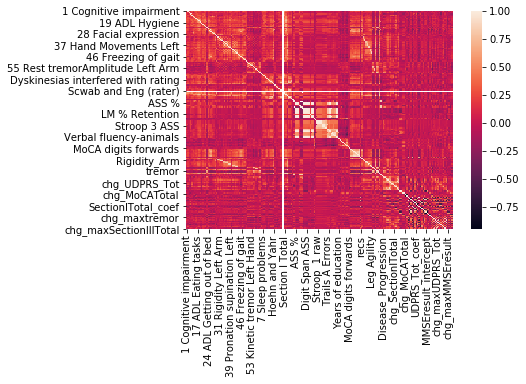

In [377]:
import seaborn as sns

mask=pd.notnull(udprs_cog_moc['total PDQ-39'])&(udprs_cog_moc['total PDQ-39']<200)
PDQ_data=udprs_cog_moc[mask]
ctscols=[col for col in PDQ_data.columns if PDQ_data[col].dtype=='float64' ]
print(len(ctscols))
sns.heatmap(PDQ_data[ctscols].corr());

In [378]:
PDQ_data[ctscols].corr()

,1 Cognitive impairment,10 Urinary problems,11 Constipation problems,12 Light headedness on standing,13 Fatigue,14 ADL Speech,15 ADL Saliva and drooling,16 ADL Chewing and swallowing,17 ADL Eating tasks,18 ADL Dressing,...,chg_minSectionITotal,chg_maxSectionIITotal,chg_minSectionIITotal,chg_maxSectionIIITotal,chg_minSectionIIITotal,chg_maxMMSEresult,chg_minMMSEresult,chg_maxMoCATotal,chg_minMoCATotal,latest_rec
1 Cognitive impairment,1.000000,0.145643,0.113237,0.254385,0.204267,0.259549,0.177004,0.237157,0.268039,0.304995,...,-0.084275,0.013700,0.035110,0.042982,0.131434,-0.093699,-0.045222,0.038527,0.015496,NaN
10 Urinary problems,0.145643,1.000000,0.174619,0.068495,0.287189,0.133337,0.281091,0.300323,0.243016,0.295873,...,-0.054245,0.087146,0.223551,-0.032782,0.004977,-0.158534,0.122020,-0.043531,0.097359,NaN
11 Constipation problems,0.113237,0.174619,1.000000,0.219006,0.148286,0.018483,0.154675,0.273562,0.123913,0.176234,...,-0.288687,0.061660,-0.016729,0.078734,-0.082497,0.018726,-0.087237,0.039174,-0.012277,NaN
12 Light headedness on standing,0.254385,0.068495,0.219006,1.000000,0.249866,0.206342,0.184465,0.268132,0.281601,0.204201,...,-0.311240,0.027841,-0.069848,0.132367,-0.022233,-0.019735,-0.054204,-0.129638,-0.178586,NaN
13 Fatigue,0.204267,0.287189,0.148286,0.249866,1.000000,0.247682,0.093807,0.213124,0.337415,0.340582,...,-0.110545,0.060841,-0.001128,0.058386,-0.020222,-0.043040,-0.100411,-0.028561,-0.080977,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chg_maxMMSEresult,-0.093699,-0.158534,0.018726,-0.019735,-0.043040,-0.160371,-0.121115,-0.115954,-0.175755,-0.268704,...,-0.126081,-0.014092,-0.157444,-0.100146,-0.238835,1.000000,0.021509,0.416706,-0.084486,NaN
chg_minMMSEresult,-0.045222,0.122020,-0.087237,-0.054204,-0.100411,-0.002215,-0.059322,0.105504,0.081750,-0.003068,...,0.172978,-0.169534,0.195657,-0.157330,0.317267,0.021509,1.000000,-0.055607,0.453561,NaN
chg_maxMoCATotal,0.038527,-0.043531,0.039174,-0.129638,-0.028561,0.005590,-0.042827,-0.015084,-0.102861,-0.112332,...,-0.302509,0.114899,-0.161205,0.122406,-0.231246,0.416706,-0.055607,1.000000,0.065477,NaN
chg_minMoCATotal,0.015496,0.097359,-0.012277,-0.178586,-0.080977,0.059317,0.053524,0.116225,0.092141,0.113764,...,0.143651,-0.105305,0.337496,-0.167000,0.466893,-0.084486,0.453561,0.065477,1.000000,NaN


In [388]:
corr=PDQ_data[ctscols].values
np.fill_diagonal(corr, np.nan)
print(corr)

[[nan  1.  1. ...  3. -9. nan]
 [ 2. nan  2. ... -2. -2. nan]
 [ 0.  0. nan ...  1.  0. nan]
 ...
 [ 1.  1.  1. ... nan nan  1.]
 [ 1.  1.  0. ... nan nan  1.]
 [ 2.  2.  0. ... -3. -3. nan]]


In [390]:
order_top2 = np.argsort(-corr, axis=1)[:, :2]
order_bottom = np.argsort(corr, axis=1)[:, :1]

result_top2 = pd.DataFrame(
    corr[order_top2], 
    columns=PDQ_data[ctscols].columns,
    index=corr.index
)

result_bottom = pd.DataFrame(
    corr.columns[order_bottom], 
    columns=['Last'],
    index=corr.index
)

result = result_top2.join(result_bottom)

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [380]:
order_top2 = np.argsort(PDQ_data.values, axis=1)[:, :2]

TypeError: '<' not supported between instances of 'int' and 'str'

In [267]:
model.score(X_test, y_test) # Returns 0.917
y_pred = model.predict(X_test)
r2_score(y_pred, y_test) # Returns 0.903

r2_score(y_pred, y_test, multioutput='variance_weighted')



0.0004728806796651109

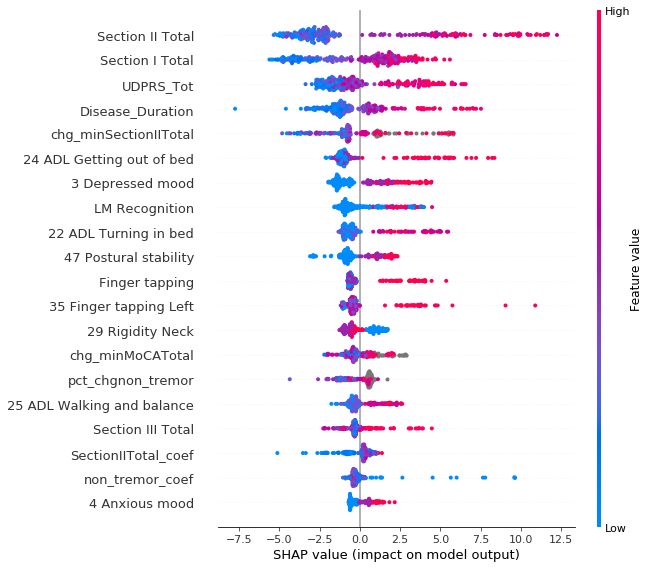

In [269]:
exp = shap.TreeExplainer(model)
shap_values = exp.shap_values(X)
shap.summary_plot(shap_values, X)

In [107]:
s = pd.DataFrame(shap_values, columns = X_test.columns)

In [108]:
s

,tremor_coef,non_tremor_coef,SectionIIITotal_coef,MMSEresult_coef,MoCATotal_coef,Age_Diagnosis,tremor,non_tremor,FOGQ 3,Section III Total,MMSE result,MoCA Total
0,-0.426950,0.339702,-1.039846,-2.634051,-0.815642,7.456398,-1.601152,7.956306,-1.676646,7.721614,14.000742,0.252513
1,0.264642,0.100419,-0.015678,0.867267,-0.290095,-2.779721,2.009008,1.249035,2.593218,4.410984,-3.289114,0.171431
2,-0.937004,-0.371962,-0.683022,-1.094005,-2.151066,-2.318195,0.183468,-0.574016,-2.059148,-6.791919,-2.848397,-0.386570
3,-0.937004,-0.371962,-0.656095,-0.770392,-2.151066,-2.824105,0.184310,-4.094361,-2.031218,-7.135652,-3.453758,-0.155255
4,-0.937004,-0.057084,-0.518796,-0.770392,-2.151066,-2.803409,0.219901,-4.128755,-2.137960,-7.135652,-2.792769,-0.698725
...,...,...,...,...,...,...,...,...,...,...,...,...
271,1.447858,0.617522,-1.015071,2.807490,-0.786316,-10.855871,2.657367,4.384261,-1.741768,15.373175,-4.158249,1.860414
272,0.638165,-0.119725,1.380548,1.919511,0.042757,-3.398348,-0.475085,-3.444611,-1.122508,-4.120155,8.845594,0.861332
273,0.609659,-0.119725,1.347701,1.892845,0.042757,-3.558294,-0.999814,-2.667713,-1.454100,-4.351126,7.913654,0.852884
274,0.064022,0.326121,0.828006,2.161385,-0.133786,-2.076565,-4.203394,4.179701,-1.860931,2.193091,-5.072238,-1.553700


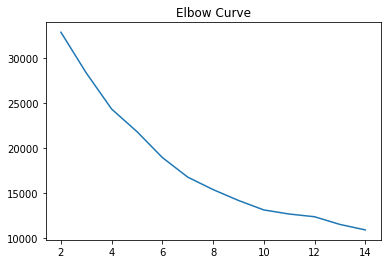

In [109]:
#convert shap_values array to dataframe

#Use Elbow method to decide the optimal number of clusters
sse = []
for k in range(2,15):
    kmeans = KMeans(n_clusters = k)
    #fit the k-means model on the shap values
    kmeans.fit(s)
    #appent the error of each iteration
    sse.append(kmeans.inertia_)
   
pl.plot(range(2,15), sse)
pl.title("Elbow Curve")
pl.show()

In [110]:
kmeans = KMeans(n_clusters = 7, random_state = 100).fit(s)
#selecting cluster centres
centroids = kmeans.cluster_centers_

In [111]:
patient = pd.DataFrame(X.index)
cluster_no = pd.DataFrame(kmeans.labels_)
df= pd.DataFrame()
#Concatenating the patient ids with the assigned cluster lables
df = pd.concat([patient,cluster_no], axis =1)
df.columns = ["patient", "cluster no"]

In [112]:
df['cluster no'].value_counts()

2    135
5     44
4     40
1     24
6     17
3     10
0      6
Name: cluster no, dtype: int64

In [64]:
df

,patient,cluster no
0,0,4
1,4,0
2,6,1
3,7,1
4,8,1
...,...,...
271,397,6
272,399,2
273,400,2
274,401,0
